In [13]:
import cv2
import os
import pandas as pd
import numpy as np
os.chdir("/Users/xuannguyet/Documents/SUDOCODE25/ViSL-100-words-Recognition-Project")

## 1. Trimmed video metrics checking 

In [14]:
def get_video_metrics(path_to_file):
    if not os.path.exists(path_to_file):
        raise FileNotFoundError(f"Video not found: {path_to_file}")

    cap = cv2.VideoCapture(path_to_file)
    if not cap.isOpened():
        raise IOError(f"Cannot open video: {path_to_file}")
    
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    fps = float(cap.get(cv2.CAP_PROP_FPS))
    duration_seconds = frame_count / fps
    
    return frame_count, fps, duration_seconds


data = []

for sub_dir in os.listdir("dataset/2011_videos"):
    if os.path.isdir(os.path.join("dataset/2011_videos", sub_dir)):
        path_to_sub_dir = os.path.join("dataset/2011_videos", sub_dir)
        #print(sub_dir)
        for file_name in os.listdir(path_to_sub_dir):
            if os.path.isfile(os.path.join(path_to_sub_dir, file_name)):
                path_to_video = os.path.join(path_to_sub_dir, file_name)
                if file_name == ".DS_Store":
                    continue
                frame_count, fps, duration_seconds = get_video_metrics(path_to_video)
                #print(f"total_frame: {frame_count}, fps: {fps:.0f}, duration_seconds: {duration_seconds:.0f}\n")
                
                data.append({
                    "label": str(sub_dir),
                    "frame_count": frame_count,
                    "fps": fps,
                    "duration_seconds": duration_seconds
                })
                
df = pd.DataFrame(data)
df.head()
#df.to_csv(os.path.join("dataset/videos copy", "video_metrics.csv"), index=False)

label  frame_count       fps  duration_seconds
0              bàn ghế          127  29.97003          4.237567
1            mầm non           69  29.97003          2.302300
2                 kẹo           76  29.97003          2.535867
3  dân tộc Mường           91  29.97003          3.036367
4     dân tộc Thái           78  29.97003          2.602600

## 2. Keypoint extractions

In [15]:
import mediapipe as mp

# Mediapipe Holistic initialization
mp_drawing = mp.solutions.drawing_utils
mp_holistic = mp.solutions.holistic
holistic = mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5)

# Determine global landmarks feature
N_HAND_LANDMARKS=21
N_UPPER_POSE_LANDMARKS=25
N_LANDMARKS=N_HAND_LANDMARKS*2 + N_UPPER_POSE_LANDMARKS

I0000 00:00:1763633916.594624   13782 gl_context.cc:369] GL version: 2.1 (2.1 INTEL-20.7.3), renderer: Intel(R) Iris(TM) Plus Graphics 640


W0000 00:00:1763633917.328436  129230 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1763633917.424944  129232 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1763633917.434627  129229 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1763633917.435536  129230 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1763633917.436351  129231 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1763633917.481500  129231 inference_feedback_manager.cc:114] Feedback manager 

In [16]:
import matplotlib.pyplot as plt
import numpy as np
import math

# MediaPipe Hands connections (21 điểm)
HAND_CONNECTIONS = [
    (0,1), (1,2), (2,3), (3,4),         # ngón cái
    (0,5), (5,6), (6,7), (7,8),         # ngón trỏ
    (5,9), (9,10), (10,11), (11,12),    # ngón giữa
    (9,13), (13,14), (14,15), (15,16),  # ngón áp út
    (13,17), (17,18), (18,19), (19,20), # ngón út
    (0,17)                              # nối lòng bàn tay
]

# MediaPipe Pose (upper-body only)
POSE_UPPER_CONNECTIONS = [
    (11,12),   # shoulders
    (11,13), (13,15),    # left arm
    (12,14), (14,16),    # right arm
    (23,11), (24,12),    # hips to shoulders
    (23, 24) # hips
]


def draw_connections(ax, points, connections, color, linewidth=1.5):
    for i, j in connections:
        if i < len(points) and j < len(points):
            p1, p2 = points[i], points[j]
            if not np.all(p1 == 0) and not np.all(p2 == 0):
                ax.plot([p1[0], p2[0]], [p1[1], p2[1]], color=color, linewidth=linewidth)


def plot_keypoints_sequence_with_connections(sequence, n_cols=5, invert_y=True):
    n_frames = len(sequence)
    n_rows = math.ceil(n_frames / n_cols)

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(3*n_cols, 3*n_rows))
    axes = axes.flatten()

    def filter_zero(arr):
        arr = np.array(arr)[:, :2]
        return arr

    for idx, frame in enumerate(sequence):
        
        ax = axes[idx]
        ax.set_facecolor('#E5E5E5')
        
        left_hand_landmarks = frame[0:N_HAND_LANDMARKS*3].reshape(N_HAND_LANDMARKS, 3)
        right_hand_landmarks = frame[N_HAND_LANDMARKS*3:N_HAND_LANDMARKS*3*2].reshape(N_HAND_LANDMARKS, 3)
        pose_landmarks = frame[N_HAND_LANDMARKS*3*2:].reshape(N_UPPER_POSE_LANDMARKS, 3)

        # left_full  = filter_zero(frame[0])
        # right_full = filter_zero(frame[1])
        # body_full  = filter_zero(frame[2])
        
        left_full  = filter_zero(left_hand_landmarks)
        right_full = filter_zero(right_hand_landmarks)
        body_full  = filter_zero(pose_landmarks)

        left  = left_full[~np.all(left_full == 0, axis=1)]
        right = right_full[~np.all(right_full == 0, axis=1)]
        body  = body_full[~np.all(body_full == 0, axis=1)]

        # --- Scatter ---
        ax.scatter(left[:,0],  left[:,1],  c='red',   s=12)
        ax.scatter(right[:,0], right[:,1], c='blue',  s=12)
        ax.scatter(body[:,0],  body[:,1],  c='green', s=18)

        # --- Connections ---
        draw_connections(ax, left_full,  HAND_CONNECTIONS, 'black')
        draw_connections(ax, right_full, HAND_CONNECTIONS, 'black')
        draw_connections(ax, body_full,  POSE_UPPER_CONNECTIONS, 'black')

        # ax.set_xlim(-1, 1)
        # ax.set_ylim(-5, 2)
        if invert_y:
            ax.invert_yaxis()

        ax.set_title(f"Frame {idx}", fontsize=10)
        ax.set_xticks([])
        ax.set_yticks([])

    #Ẩn subplot thừa
    for j in range(idx+1, len(axes)):
        axes[j].axis()

    plt.tight_layout()
    plt.show()

In [17]:
def draw_styled_landmarks(image, results):
    # Draw pose connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(80,22,10), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(80,44,121), thickness=2, circle_radius=2)
                             ) 
    # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(121,22,76), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(121,44,250), thickness=2, circle_radius=2)
                             ) 
    # Draw right hand connections  
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)
                             ) 

def mediapipe_detection(image, model):
    """Convert color space and run Mediapipe model."""
    
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image.flags.writeable = False
    results = model.process(image)
    image.flags.writeable = True
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    return image, results

def extract_keypoints(results):
    """ """
    
    # Hands extraction
    left_hand_landmarks = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(N_HAND_LANDMARKS*3)
    right_hand_landmarks = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(N_HAND_LANDMARKS*3)
    
    # Upper pose extraction
    pose_landmarks = []
    if results.pose_landmarks:
        for i, res in enumerate(results.pose_landmarks.landmark):
            if i < N_UPPER_POSE_LANDMARKS: # only capture 25 landmarks in upper body
                pose_landmarks.append([res.x, res.y, res.z])
        pose_landmarks = np.array(pose_landmarks).flatten()
    else:
        pose_landmarks = np.zeros(N_UPPER_POSE_LANDMARKS*3)
    
    return np.concatenate([left_hand_landmarks, right_hand_landmarks, pose_landmarks])

def process_video_to_sequence(path_to_video, model):
    """Processing one video to keypoints sequence through Mediapipe detection."""

    keypoints_sequence = []
    
    cap = cv2.VideoCapture(path_to_video)
    if not cap.isOpened():
        raise IOError(f"Cannot open video: {path_to_video}")
    
    while True:
        # Read feed
        ret, frame = cap.read()
        if not ret:
            break
        # Make detections
        image, results = mediapipe_detection(frame, model)
        keypoints = extract_keypoints(results)
        if np.all(keypoints[:N_HAND_LANDMARKS*2] == 0.0):
            # print(f" WARNING: No hand detection.")
            continue
        if keypoints is not None:
            keypoints_sequence.append(keypoints)
    cap.release()
    return keypoints_sequence

In [18]:
# Process videos to sequence
output_dir = "dataset/2011_keypoints"
n_action=1
actions = []
for action in os.listdir("dataset/2011_videos"):
    if os.path.isdir(os.path.join("dataset/2011_videos", action)):
        print(f"{n_action}. Starting process '{action}' video.")
        path_to_action_dir = os.path.join("dataset/2011_videos", action)
        i = 0
        for file_name in os.listdir(path_to_action_dir):
            if file_name == ".DS_Store":
                continue
            if os.path.isfile(os.path.join(path_to_action_dir, file_name)):
                path_to_video = os.path.join(path_to_action_dir, file_name)
                try:
                    keypoints_sequence = process_video_to_sequence(path_to_video, holistic)
                except Exception as e:
                    print(f" ERROR: Can not extract keypoints from {path_to_video} due to {e}. Skipping.")
                    continue
                if keypoints_sequence is None or len(keypoints_sequence) < 25:
                    try:
                        print(f" Only have {len(keypoints_sequence)} frames contain hand dection.")
                    except:
                        continue
                    print(" Not enough frames to save. Skip.")
                    continue
                path_to_new_action_dir = os.path.join(output_dir, action)
                os.makedirs(path_to_new_action_dir, exist_ok=True)
                path_to_new_file = os.path.join(path_to_new_action_dir, f"{i}.npy")
                np.save(path_to_new_file, keypoints_sequence)
                i += 1
        print(f" ok writing {i} .npy files from {path_to_action_dir}.")
        if i > 0:
            actions.append(str(action))
    n_action+=1
print(f"PROCESSING VIDEO TO DATA DONE.")
print(f"Number of collected actions: {len(actions)}.")
                

1. Starting process 'bàn ghế' video.
 ok writing 1 .npy files from dataset/2011_videos/bàn ghế.
2. Starting process 'mầm non' video.
 ok writing 1 .npy files from dataset/2011_videos/mầm non.
3. Starting process 'kẹo' video.
 ok writing 1 .npy files from dataset/2011_videos/kẹo.
4. Starting process 'dân tộc Mường' video.
 ok writing 1 .npy files from dataset/2011_videos/dân tộc Mường.
5. Starting process 'dân tộc Thái' video.
 ok writing 1 .npy files from dataset/2011_videos/dân tộc Thái.
6. Starting process 'ấm đun nước' video.
 Only have 0 frames contain hand dection.
 Not enough frames to save. Skip.
 ok writing 0 .npy files from dataset/2011_videos/ấm đun nước.
7. Starting process 'tấm lòng' video.
 ok writing 1 .npy files from dataset/2011_videos/tấm lòng.
8. Starting process 'miền Nam Việt Nam' video.
 ok writing 1 .npy files from dataset/2011_videos/miền Nam Việt Nam.
9. Starting process 'tàu hoả' video.
 ok writing 1 .npy files 

In [19]:
label_map = {label:num for num, label in enumerate(sorted(actions))}
import json
path_to_labelmap_file = os.path.join(output_dir, "label_map.json")
with open(path_to_labelmap_file, "w", encoding="utf-8") as f:
    json.dump(label_map, f, ensure_ascii=False, indent=4)

print(f"Label map saved to {path_to_labelmap_file}.")

Label map saved to dataset/2011_keypoints/label_map.json.


## 3. Data Validation

In [20]:
import json
output_dir = "dataset/2011_keypoints"
path_to_labelmap_file = os.path.join(output_dir, "label_map.json")
with open(path_to_labelmap_file, "r", encoding="utf-8") as f:
    label_map = json.load(f)
    
num_to_label = {v: k for k, v in label_map.items()}
print(num_to_label)

{0: 'Bắc Bộ', 1: 'Tây Nguyên', 2: 'bánh cốm', 3: 'bánh giầy', 4: 'bánh hamburger', 5: 'bánh pía', 6: 'bánh sandwich', 7: 'bánh đa', 8: 'buôn làng', 9: 'buổi chiều', 10: 'buổi sáng', 11: 'buổi trưa', 12: 'buổi đêm', 13: 'bàn ghế', 14: 'bạn', 15: 'cây đa', 16: 'chai nước', 17: 'chính phủ', 18: 'chung kết', 19: 'con bướm', 20: 'con bò', 21: 'con chuồn chuồn', 22: 'con công', 23: 'con cua', 24: 'con cừu', 25: 'con cá', 26: 'con dê', 27: 'con gà', 28: 'con mèo', 29: 'con ngỗng', 30: 'con tôm', 31: 'con voi', 32: 'con vượn', 33: 'cô giáo', 34: 'dân tộc', 35: 'dân tộc Chăm', 36: 'dân tộc Khơ me', 37: 'dân tộc Mường', 38: 'dân tộc Thái', 39: 'giao thông', 40: 'giấy ăn', 41: 'hải đảo', 42: 'hoa giấy', 43: 'hoa hồng', 44: 'hoa mai', 45: 'hoa sen', 46: 'hoa đào', 47: 'kẹo', 48: 'khẩu trang', 49: 'khăn quàng', 50: 'khoẻ mạnh', 51: 'mái chèo', 52: 'máy tính laptop', 53: 'mầm non', 54: 'miền Bắc Việt

In [21]:
for action in sorted(os.listdir(output_dir)):
    if os.path.isdir(os.path.join(output_dir, action)):
        path_to_action_dir = os.path.join(output_dir, action)
        for file_name in os.listdir(path_to_action_dir):
            path_to_file = os.path.join(path_to_action_dir, file_name)
            sequence = np.load(path_to_file, allow_pickle=True)
            print(f"{action}: {len(sequence)} frames.")
            for i, frame in enumerate(sequence):
                if np.all(frame[:N_HAND_LANDMARKS*2] == 0.0):
                    print(f" WARNING: No hand detection at frame {i} of action {action}.")
print(f"Number of new actions: {len(os.listdir(output_dir))-1}")

Bắc Bộ: 57 frames.
Tây Nguyên: 58 frames.
bánh cốm: 53 frames.
bánh giầy: 65 frames.
bánh hamburger: 59 frames.
bánh pía: 81 frames.
bánh sandwich: 41 frames.
bánh đa: 63 frames.
buôn làng: 54 frames.
buổi chiều: 47 frames.
buổi sáng: 47 frames.
buổi trưa: 56 frames.
buổi đêm: 58 frames.
bàn ghế: 71 frames.
bạn: 57 frames.
cây đa: 64 frames.
chai nước: 51 frames.
chính phủ: 61 frames.
chung kết: 55 frames.
con bướm: 51 frames.
con bò: 41 frames.
con chuồn chuồn: 49 frames.
con công: 55 frames.
con cua: 55 frames.
con cừu: 60 frames.
con cá: 52 frames.
con dê: 30 frames.
con gà: 51 frames.
con mèo: 51 frames.
con ngỗng: 51 frames.
con tôm: 51 frames.
con voi: 67 frames.
con vượn: 58 frames.
cô giáo: 69 frames.
dân tộc: 59 frames.
dân tộc Chăm: 58 frames.
dân tộc Khơ me: 65 frames.
dân tộc Mường: 53 frames.
dân tộc Thái: 46 frames.
giao thông: 49 frames.
giấy ăn: 66 frames.
hải đảo: 53 frames.
hoa giấy: 43 

hoa mai


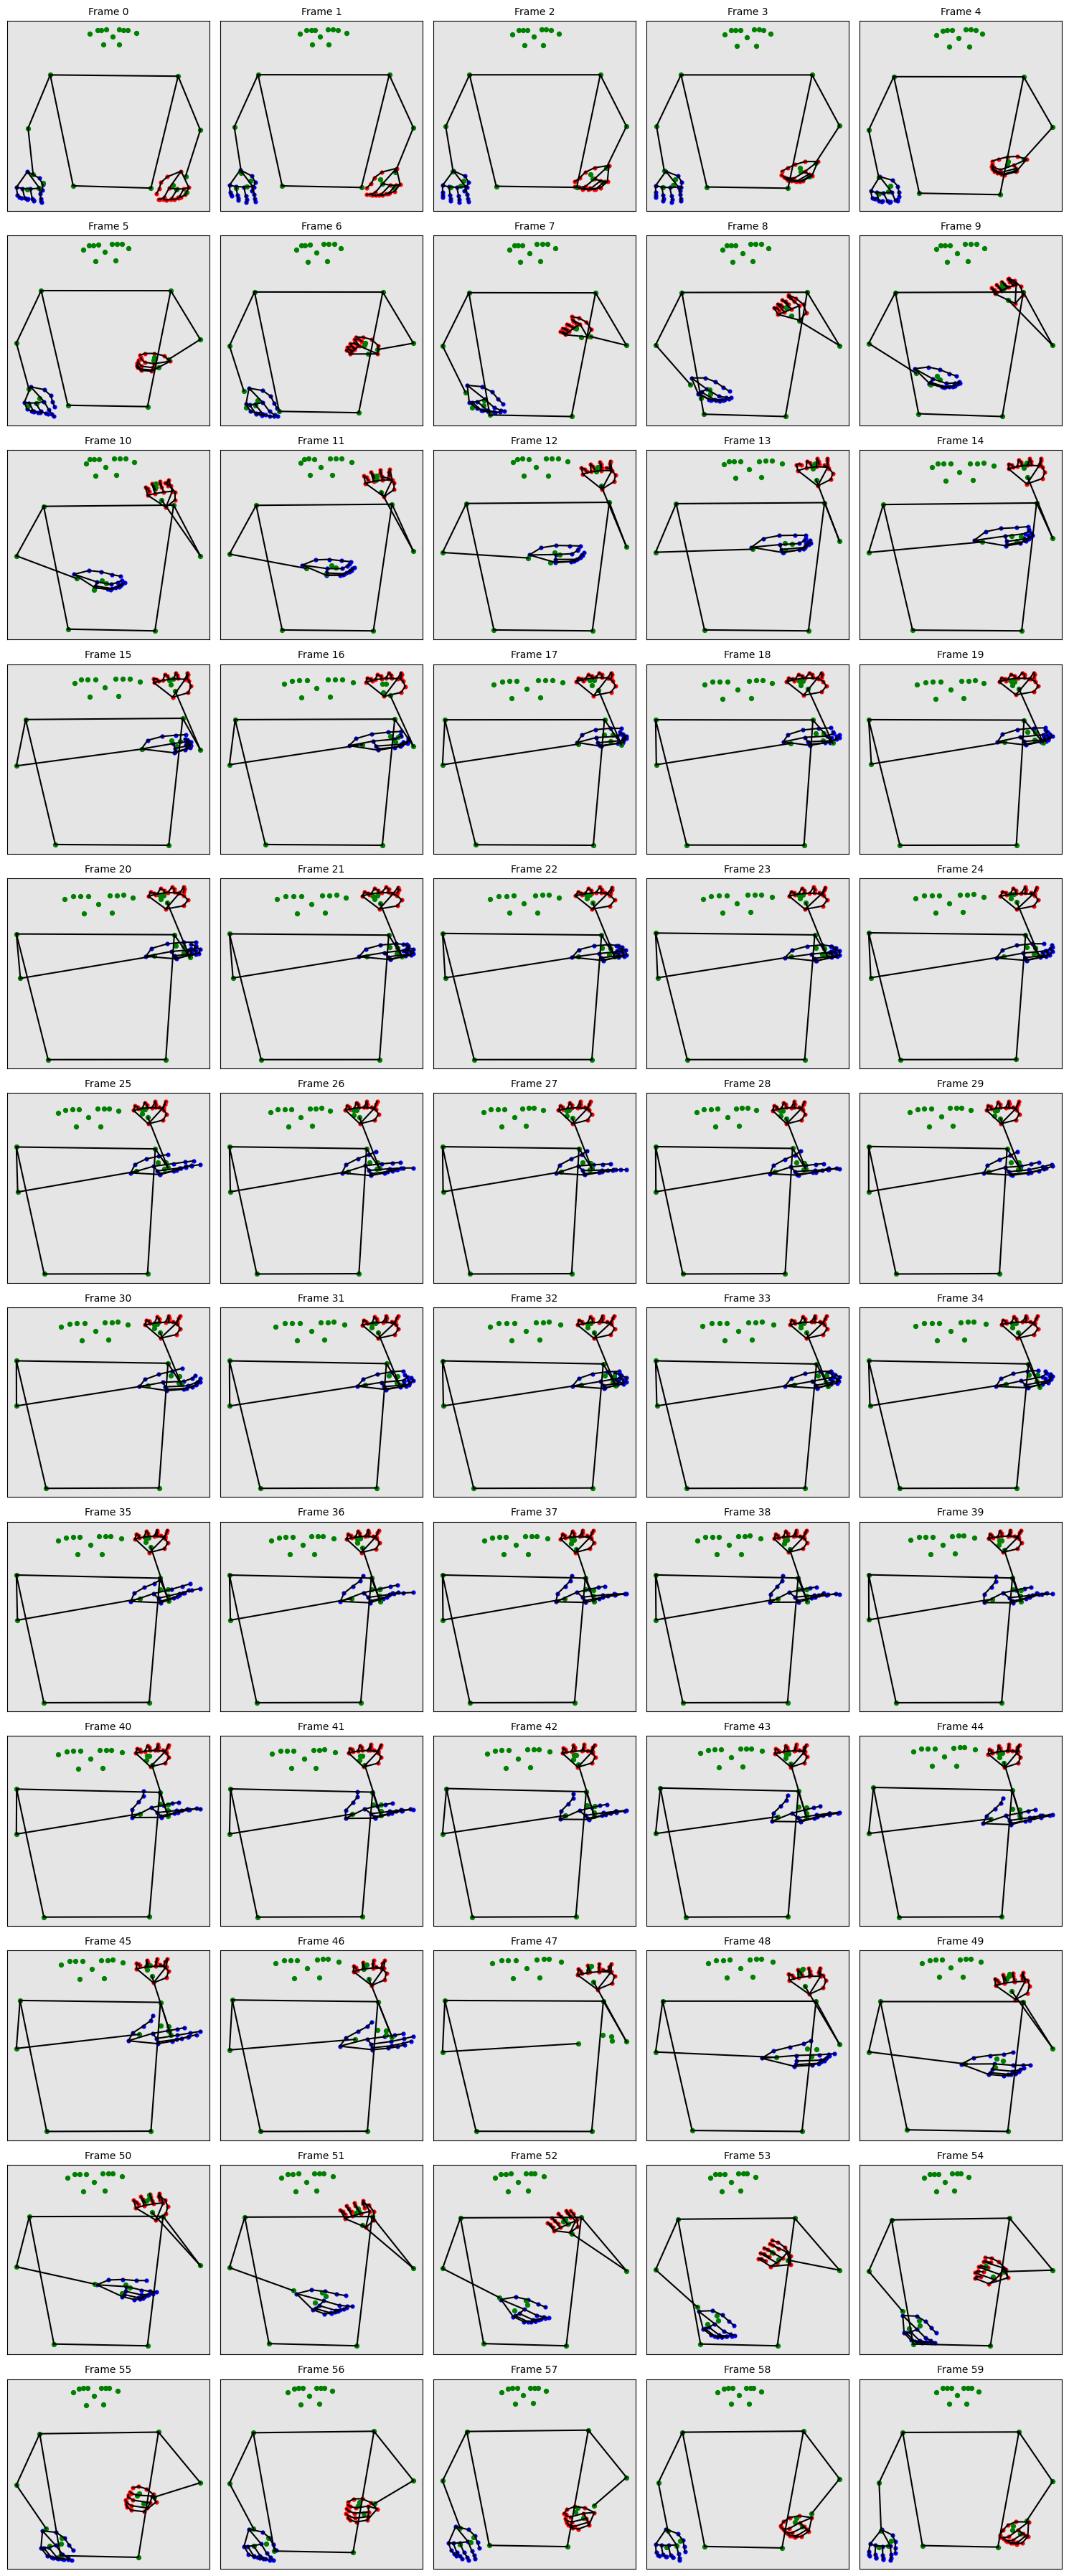

In [22]:
import random
all_dirs = [d for d in os.listdir(output_dir) if os.path.isdir(os.path.join(output_dir, d))]
random_dir = random.choice(all_dirs)
print(random_dir)
path_to_dir = os.path.join(output_dir, random_dir)
path_to_file = os.path.join(path_to_dir, "0.npy")
sample = np.load(path_to_file, allow_pickle=True)
plot_keypoints_sequence_with_connections(sample)

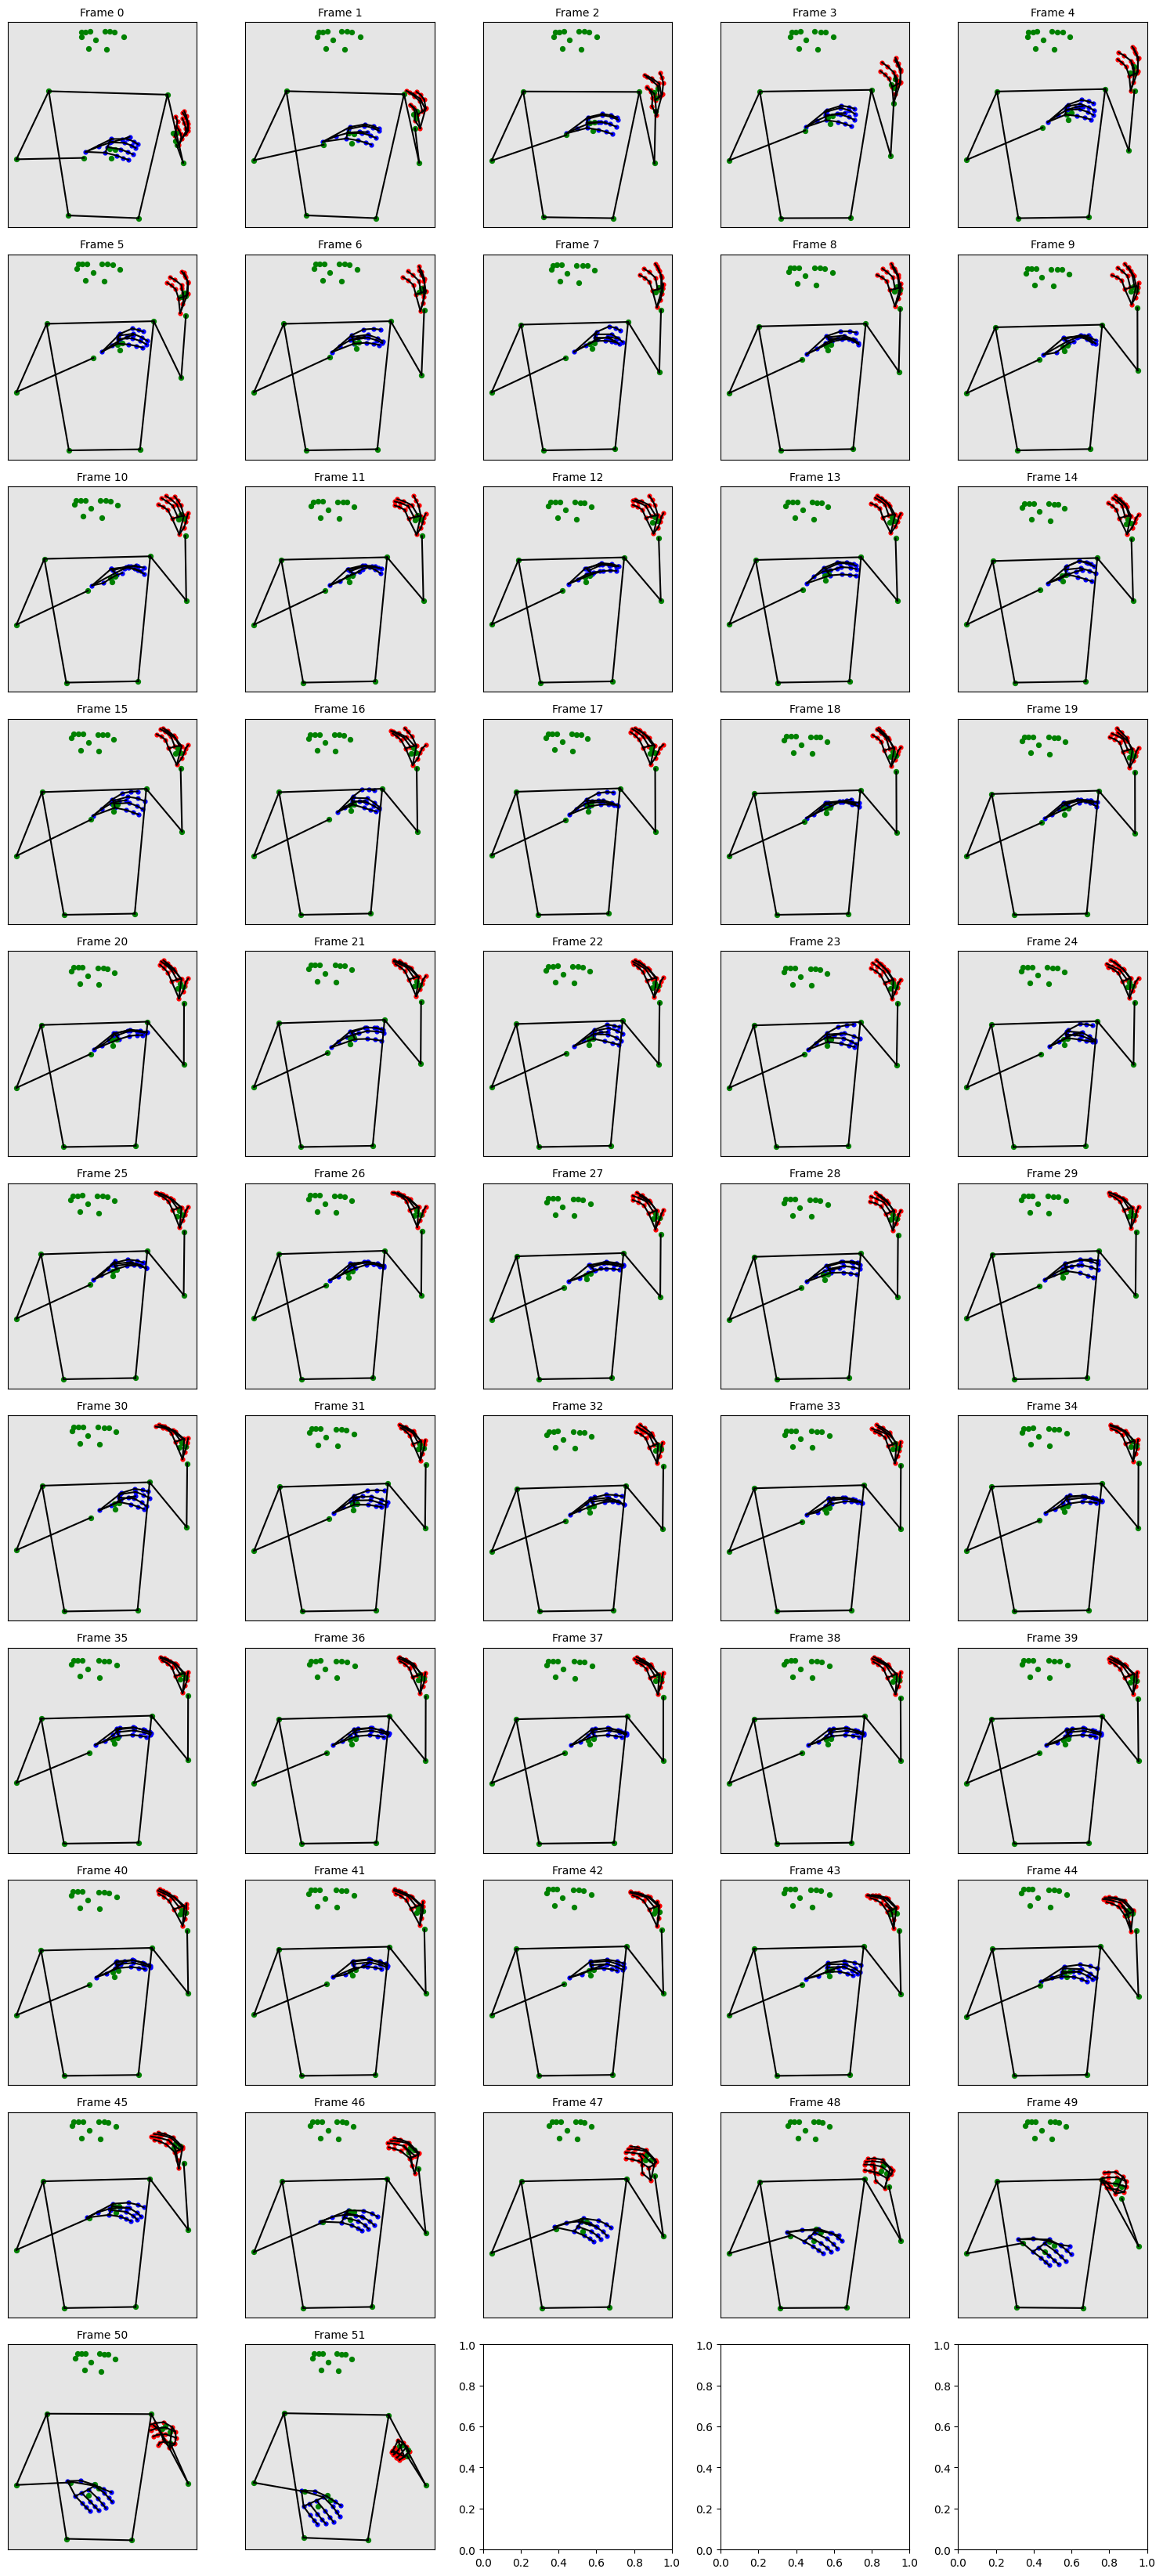

In [24]:
sample = np.load("dataset/final_keypoints/máy tính laptop/0.npy", allow_pickle=True)
plot_keypoints_sequence_with_connections(sample)

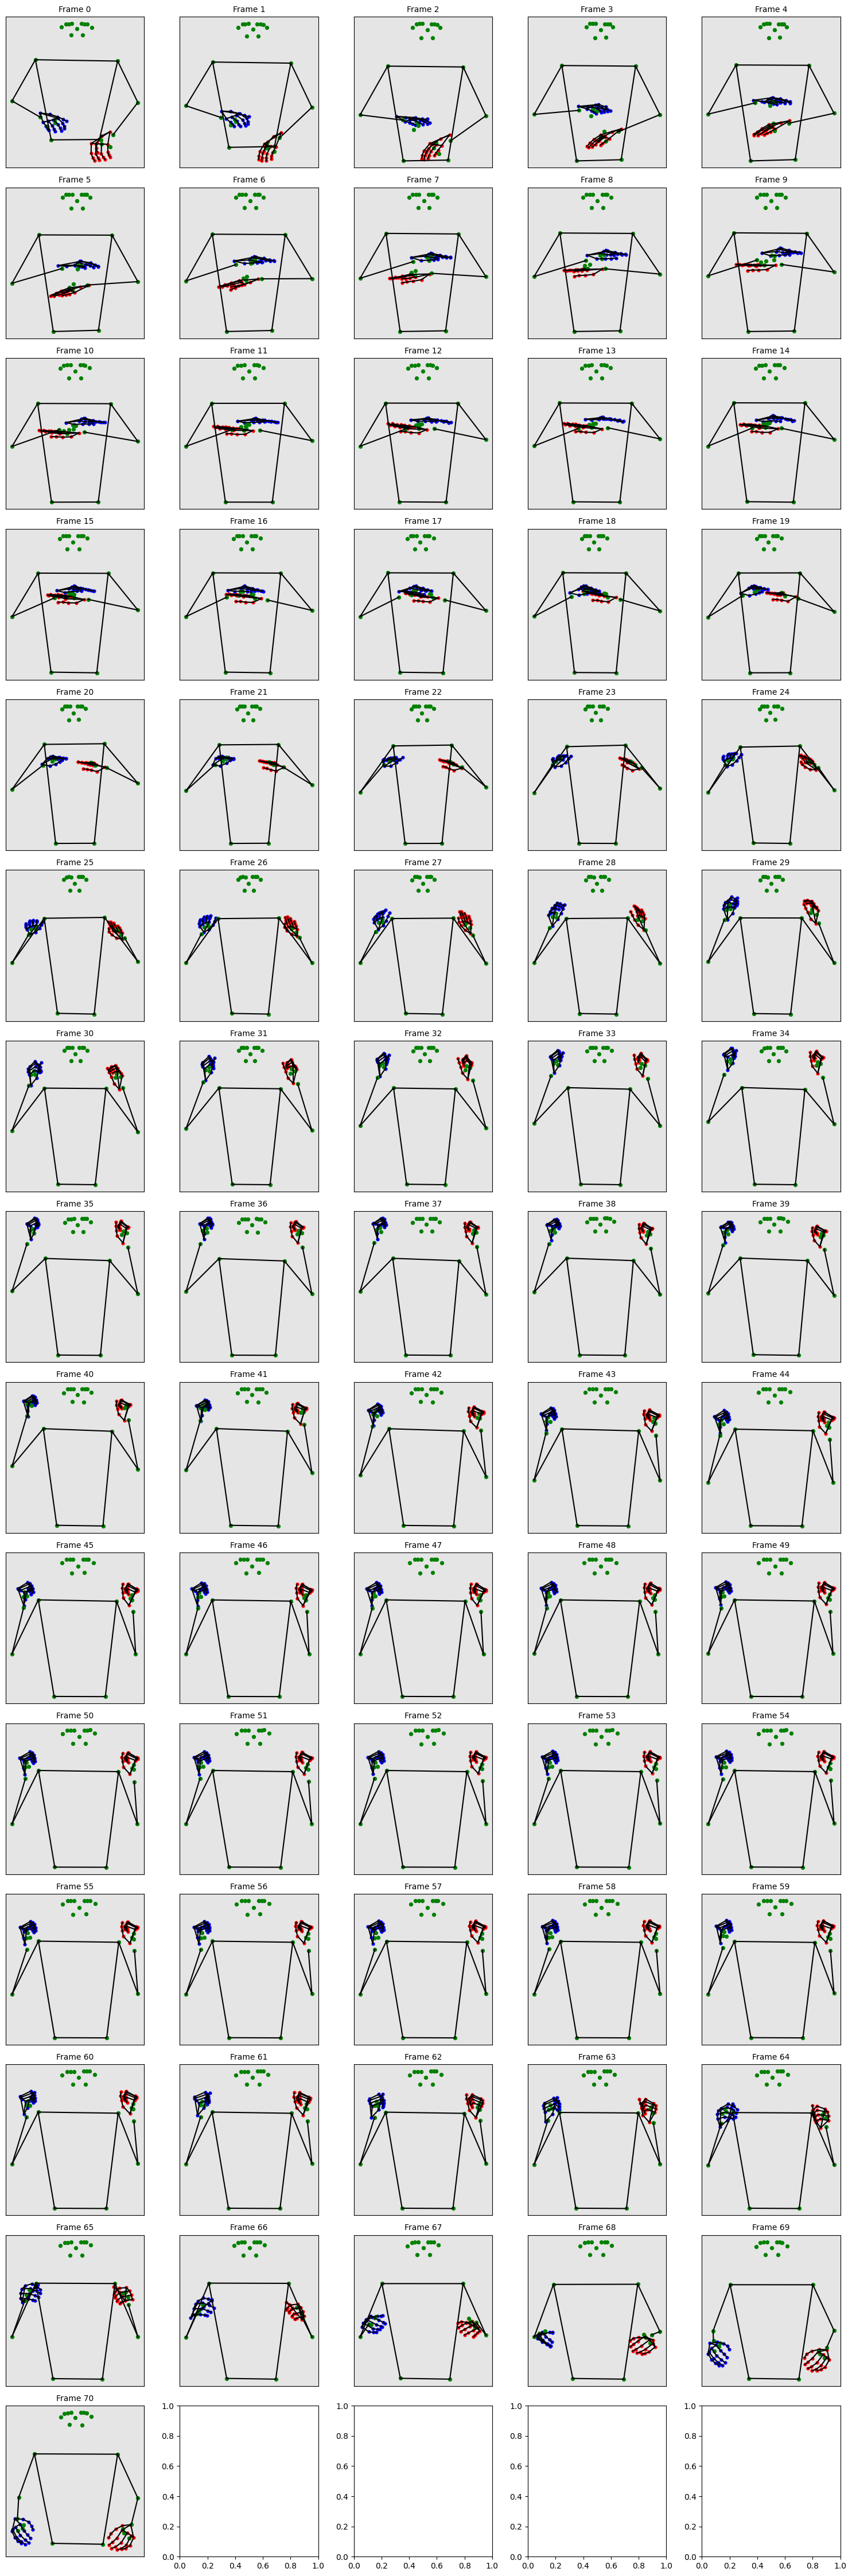

In [25]:
sample = np.load("dataset/final_keypoints/bàn ghế/0.npy", allow_pickle=True)
plot_keypoints_sequence_with_connections(sample)

## 4. Interpolate

In [26]:
def interpolate_keypoints_sequence(keypoints_sequence, target_len=30):
    """Interpolate keypoints sequence into new sequence which has 60 frames for output."""
    
    sequence = np.array(keypoints_sequence.copy())
    n_frames, n_features = sequence.shape
    
    if n_frames == target_len:
        return sequence.copy()
    
    origin_indices = np.arange(n_frames)
    new_indices = np.linspace(0, n_frames - 1, target_len)
    
    interp_sequence = np.zeros((target_len, n_features))
    for i in range(n_features):
        interp_sequence[:, i] = np.interp(new_indices, origin_indices, sequence[:, i])
        
    return interp_sequence

## 5. Augmentation functions

In [27]:
import random
def scale_keypoints_sequence(keypoints_sequence, scale_range=(0.9, 1.26), n_landmarks=N_LANDMARKS, n_hand_landmarks=N_HAND_LANDMARKS, n_pose_landmarks=N_UPPER_POSE_LANDMARKS):
    """
    Apply 2D scaling transformation for a sequence of keypoints.
    _random scale weight is used consistently for all frames in sequence.
    _center point to scale is computed by median based on the keypoints specified in that frame.
    _scaled point coordinates are normalized to (0,1) range.
    """
    
    results = []
    if keypoints_sequence is None:
        return keypoints_sequence
    
    # Determine a random scale weight for all frames in sequence of keypoints
    w_scale = random.uniform(scale_range[0], scale_range[1])

    if w_scale <= 0:
        print(f"WARNING: Scale weight must be positive.")
        return keypoints_sequence
    
    for frame_keypoints in keypoints_sequence:
        if frame_keypoints is None:
            results.append(frame_keypoints.copy())
            continue
        
        if not isinstance(frame_keypoints, np.ndarray) or frame_keypoints.shape != (n_landmarks*3,):
            results.append(frame_keypoints.copy())
            continue
        
        flat_points = frame_keypoints.copy()
        try:
            points_3d = flat_points.reshape(n_landmarks,3)
        except ValueError:
            results.append(frame_keypoints.copy())
            continue   
        
        # Approximate body center
        x_center, y_center = 0.0, 0.0
        flag = False
        selected_points = points_3d[0:n_landmarks-2] # not using left-hip and right-hip
        if selected_points is not None:
            center_mask = np.any(selected_points != 0, axis=1)
            valid_points = selected_points[center_mask]
            if valid_points.shape[0] > 0:
                x_center = np.median(valid_points[:, 0])
                y_center = np.median(valid_points[:, 1])
                flag = True
            else:
                print(f"WARNING: No point is available for calculating center point.")
            
        if flag:
            # only scale points that not (0, 0, 0)
            scale_mask = np.any(points_3d != 0, axis=1)
            if np.any(scale_mask):
                x_points = points_3d[scale_mask, 0]
                y_points = points_3d[scale_mask, 1]
                
                x_trans = x_points - x_center
                y_trans = y_points - y_center
                x_scaled = x_trans * w_scale
                y_scaled = y_trans * w_scale
                x_new_points = x_scaled + x_center
                y_new_points = y_scaled + y_center
                
                points_3d[scale_mask, 0] = x_new_points
                points_3d[scale_mask, 1] = y_new_points
        # if flag=Fasle: points_3d have no changed.
    

        processed_output = points_3d.flatten()

        if np.isnan(processed_output).any() or np.isinf(processed_output).any():
            results.append(frame_keypoints.copy()) # Keep the same origin frame if NaN/Inf error
        else:
            results.append(processed_output)
        
    return results   

In [33]:
import math
def rotate_keypoints_sequence(keypoints_sequence, angle_range=(-10,10), n_landmarks=N_LANDMARKS, n_hand_landmarks=N_HAND_LANDMARKS, n_pose_landmarks=N_UPPER_POSE_LANDMARKS):
    """
    Apply 2D rotation transformation for a sequence of keypoints.
    _random angle is used consistently for all frames in sequence.
    _center point to rotate is computed by median based on the keypoints specified in that frame.
    """
    results = []
    if keypoints_sequence is None:
        return keypoints_sequence
    
    # Determine a random angle for all frames in sequence of keypoints
    d_angle = random.uniform(angle_range[0], angle_range[1])
    
    # compute sin/cos with angle in radian
    r_angle = math.radians(d_angle)
    cos_angle = math.cos(r_angle)
    sin_angle = math.sin(r_angle)
    
    for frame_keypoints in keypoints_sequence:
        if frame_keypoints is None:
            results.append(frame_keypoints.copy())
            continue
        
        if not isinstance(frame_keypoints, np.ndarray) or frame_keypoints.shape != (n_landmarks*3,):
            results.append(frame_keypoints.copy())
            continue
        
        flat_points = frame_keypoints.copy()
        try:
            points_3d = flat_points.reshape(n_landmarks,3)
        except ValueError:
            results.append(frame_keypoints.copy())
            continue
        
        # Approximate body center
        x_center, y_center = 0.0, 0.0
        flag = False
        selected_points = points_3d[0:n_landmarks-2] # not using left-hip and right-hip
        if selected_points is not None:
            center_mask = np.any(selected_points != 0, axis=1)
            valid_points = selected_points[center_mask]
            if valid_points.shape[0] > 0:
                x_center = np.median(valid_points[:, 0])
                y_center = np.median(valid_points[:, 1])
                flag = True
            else:
                print(f"WARNING: No point is available for calculating center point.")
        
        if flag:
            # only rotate points that not (0, 0, 0)
            rotate_mask = np.any(points_3d != 0, axis=1)
            if np.any(rotate_mask):
                x_points = points_3d[rotate_mask, 0]
                y_points = points_3d[rotate_mask, 1]
                
                x_trans = x_points - x_center
                y_trans = y_points - y_center
                
                x_rotated = x_trans * cos_angle - y_trans * sin_angle
                y_rotated = x_trans * sin_angle + y_trans * cos_angle

                x_new_points = x_rotated + x_center
                y_new_points = y_rotated + y_center
                
                points_3d[rotate_mask, 0] = x_new_points
                points_3d[rotate_mask, 1] = y_new_points
        # if flag=Fasle: points_3d have no changed.

        processed_output = points_3d.flatten()

        if np.isnan(processed_output).any() or np.isinf(processed_output).any():
            results.append(frame_keypoints.copy()) # Keep the same origin frame if NaN/Inf error
        else:
            results.append(processed_output)
        
    return results

In [29]:
def translate_keypoints_sequence(keypoints_sequence, trans_x_range = (-0.05, 0.05), trans_y_range = (-0.05, 0.05),
                                 n_landmarks= N_LANDMARKS, n_hand_landmarks=N_HAND_LANDMARKS, n_pose_landmarks=N_UPPER_POSE_LANDMARKS):
    """
    Apply 2D translation transformation for a sequence of keypoints.
    _random translated weight is used consistently for all frames in sequence.
    """
    results = []
    if keypoints_sequence is None:
        return keypoints_sequence
    
    # Determine a random angle for all frames in sequence of keypoints
    dx = random.uniform(trans_x_range[0], trans_x_range[1])
    dy = random.uniform(trans_y_range[0], trans_y_range[1])

    
    for frame_keypoints in keypoints_sequence:
        if frame_keypoints is None:
            results.append(frame_keypoints.copy())
            continue
        
        if not isinstance(frame_keypoints, np.ndarray) or frame_keypoints.shape != (n_landmarks*3,):
            results.append(frame_keypoints.copy())
            continue
        
        flat_points = frame_keypoints.copy()
        try:
            points_3d = flat_points.reshape(n_landmarks,3)
        except ValueError:
            results.append(frame_keypoints.copy())
            continue
        
        # only translate points that not (0, 0, 0) # x_new = x_old + dx
        trans_mask = np.any(points_3d != 0, axis=1)
        if np.any(trans_mask):
            points_3d[trans_mask, 0] += dx 
            points_3d[trans_mask, 1] += dy
            
        
        processed_output = points_3d.flatten()

        if np.isnan(processed_output).any() or np.isinf(processed_output).any():
            results.append(frame_keypoints.copy()) # Keep the same origin frame if NaN/Inf error
        else:
            results.append(processed_output)
        
    return results

In [30]:
def time_stretch_keypoints_sequence(keypoints_sequence, speed_range= (0.8, 1.2)):
    """
    Change the speed of a sequence of keypoints by resampling frames.
    _a random or fixed speed_range is applied.
    """
    
    results = []
    if keypoints_sequence is None or all(frame is None for frame in keypoints_sequence):
        return keypoints_sequence
    
    valid_frames = [frame for frame in keypoints_sequence if frame is not None]
    n_origin_frames = len(valid_frames)
    
    w_speed = random.uniform(speed_range[0], speed_range[1])
    if w_speed == 1.0: # nothing to change
        return keypoints_sequence
    
    n_new_frames = int(round(n_origin_frames / w_speed))
    if n_new_frames == 0:
        if n_origin_frames > 0:
            results.append(valid_frames[0].copy() if valid_frames[0] is not None else None)
        return results
    
    # Create frame index for sampling
    original_indices = np.linspace(0, n_origin_frames - 1, n_new_frames)
    resampled_indices = np.round(original_indices).astype(int)
    resampled_indices = np.clip(resampled_indices, 0, n_origin_frames - 1)
    
    for res_idx in resampled_indices:
        results.append(valid_frames[res_idx].copy())
        
    return results

## 6. Generate data

In [34]:
def generate_new_data_v1(origin_sequence, augmentation_functions, n_samples: int, n_func_per_sample=3):
    """Generate multiple patterns by randomly combining augmentation functions."""
    
    new_samples = []
    if origin_sequence is None or augmentation_functions is None:
        return new_samples
    
    n_available_func = len(augmentation_functions)
    for i in range(n_samples):
        # make a copy to start generating
        curr_sequence = [frame.copy() if isinstance(frame, np.ndarray) else frame for frame in origin_sequence] 
        
        # Select number of augmentation functions: from 1 to n_func_per_sample and not over n_available_func
        n_augs_to_apply = random.randint(1, min(n_func_per_sample, n_available_func))
        # Select random augmentation functions from list (not repeat)
        selected_funcs_indices = random.sample(range(n_available_func), n_augs_to_apply)
        selected_aug_funcs = [augmentation_functions[idx] for idx in selected_funcs_indices]
        # Shuffle apply order
        random.shuffle(selected_aug_funcs)
        
        for augmentation_func in selected_aug_funcs:
            curr_sequence = augmentation_func(curr_sequence)
            if curr_sequence is None or all(frame is None for frame in curr_sequence):
                break
        
        if not curr_sequence or all(frame is None for frame in curr_sequence):
            continue 
        
        new_samples.append(curr_sequence)
        
    return new_samples


In [35]:
# ------------------------------------------------------------------------------------------------------------------

# Data Version: Full augmentation functions +  Interpolate 30 frames at load in data for training

# ------------------------------------------------------------------------------------------------------------------

KEYPOINT_DATA = os.path.join("dataset/2011_keypoints")
TRAIN_DATA = os.path.join("dataset/2011_train")

os.makedirs(TRAIN_DATA, exist_ok=True)

augmentations = [
    scale_keypoints_sequence,
    rotate_keypoints_sequence,
    translate_keypoints_sequence,
    time_stretch_keypoints_sequence
]

from tqdm import tqdm
for action in sorted(os.listdir(KEYPOINT_DATA)):
    path_origin_action = os.path.join(KEYPOINT_DATA, action)
    path_output_action = os.path.join(TRAIN_DATA, action)
    
    if not os.path.isdir(path_origin_action):
        continue
    os.makedirs(path_output_action, exist_ok=True)
    idx=0
    file_list = os.listdir(path_origin_action)
    for file_name in tqdm(file_list, desc=f"Action {action}"):
        path_to_file = os.path.join(path_origin_action, file_name)
        origin_sequence = np.load(path_to_file, allow_pickle=True)
        
        augmented_sequences = generate_new_data_v1(origin_sequence, augmentations, n_samples=299)
        augmented_sequences.append(origin_sequence) # 99+1=100 samples
        print(f"Number of augmented sequences: {len(augmented_sequences)}")
        
        for sequence in augmented_sequences:
            new_path = os.path.join(path_output_action, f'{idx}.npy')
            np.save(new_path, sequence)
            idx += 1
    print(f"ok generate {idx} data for {action} and save into {path_output_action}.")

Action Bắc Bộ:   0%|          | 0/1 [00:00<?, ?it/s]

Number of augmented sequences: 300


Action Bắc Bộ: 100%|██████████| 1/1 [00:08<00:00,  8.11s/it]


ok generate 300 data for Bắc Bộ and save into dataset/2011_train/Bắc Bộ.


Action Tây Nguyên:   0%|          | 0/1 [00:00<?, ?it/s]

Number of augmented sequences: 300


Action Tây Nguyên: 100%|██████████| 1/1 [00:11<00:00, 11.67s/it]


ok generate 300 data for Tây Nguyên and save into dataset/2011_train/Tây Nguyên.


Action bánh cốm:   0%|          | 0/1 [00:00<?, ?it/s]

Number of augmented sequences: 300


Action bánh cốm: 100%|██████████| 1/1 [00:11<00:00, 11.10s/it]


ok generate 300 data for bánh cốm and save into dataset/2011_train/bánh cốm.


Action bánh giầy:   0%|          | 0/1 [00:00<?, ?it/s]

Number of augmented sequences: 300


Action bánh giầy: 100%|██████████| 1/1 [00:09<00:00,  9.07s/it]


ok generate 300 data for bánh giầy and save into dataset/2011_train/bánh giầy.


Action bánh hamburger:   0%|          | 0/1 [00:00<?, ?it/s]

Number of augmented sequences: 300


Action bánh hamburger: 100%|██████████| 1/1 [00:07<00:00,  7.39s/it]


ok generate 300 data for bánh hamburger and save into dataset/2011_train/bánh hamburger.


Action bánh pía:   0%|          | 0/1 [00:00<?, ?it/s]

Number of augmented sequences: 300


Action bánh pía: 100%|██████████| 1/1 [00:06<00:00,  6.24s/it]


ok generate 300 data for bánh pía and save into dataset/2011_train/bánh pía.


Action bánh sandwich:   0%|          | 0/1 [00:00<?, ?it/s]

Number of augmented sequences: 300


Action bánh sandwich: 100%|██████████| 1/1 [00:05<00:00,  5.38s/it]


ok generate 300 data for bánh sandwich and save into dataset/2011_train/bánh sandwich.


Action bánh đa:   0%|          | 0/1 [00:00<?, ?it/s]

Number of augmented sequences: 300


Action bánh đa: 100%|██████████| 1/1 [00:11<00:00, 11.89s/it]


ok generate 300 data for bánh đa and save into dataset/2011_train/bánh đa.


Action buôn làng:   0%|          | 0/1 [00:00<?, ?it/s]

Number of augmented sequences: 300


Action buôn làng: 100%|██████████| 1/1 [00:07<00:00,  7.76s/it]


ok generate 300 data for buôn làng and save into dataset/2011_train/buôn làng.


Action buổi chiều:   0%|          | 0/1 [00:00<?, ?it/s]

Number of augmented sequences: 300


Action buổi chiều: 100%|██████████| 1/1 [00:04<00:00,  4.40s/it]


ok generate 300 data for buổi chiều and save into dataset/2011_train/buổi chiều.


Action buổi sáng:   0%|          | 0/1 [00:00<?, ?it/s]

Number of augmented sequences: 300


Action buổi sáng: 100%|██████████| 1/1 [00:03<00:00,  3.90s/it]


ok generate 300 data for buổi sáng and save into dataset/2011_train/buổi sáng.


Action buổi trưa:   0%|          | 0/1 [00:00<?, ?it/s]

Number of augmented sequences: 300


Action buổi trưa: 100%|██████████| 1/1 [00:04<00:00,  4.58s/it]


ok generate 300 data for buổi trưa and save into dataset/2011_train/buổi trưa.


Action buổi đêm:   0%|          | 0/1 [00:00<?, ?it/s]

Number of augmented sequences: 300


Action buổi đêm: 100%|██████████| 1/1 [00:05<00:00,  5.41s/it]


ok generate 300 data for buổi đêm and save into dataset/2011_train/buổi đêm.


Action bàn ghế:   0%|          | 0/1 [00:00<?, ?it/s]

Number of augmented sequences: 300


Action bàn ghế: 100%|██████████| 1/1 [00:05<00:00,  5.35s/it]


ok generate 300 data for bàn ghế and save into dataset/2011_train/bàn ghế.


Action bạn:   0%|          | 0/1 [00:00<?, ?it/s]

Number of augmented sequences: 300


Action bạn: 100%|██████████| 1/1 [00:04<00:00,  4.86s/it]


ok generate 300 data for bạn and save into dataset/2011_train/bạn.


Action cây đa:   0%|          | 0/1 [00:00<?, ?it/s]

Number of augmented sequences: 300


Action cây đa: 100%|██████████| 1/1 [00:05<00:00,  5.20s/it]


ok generate 300 data for cây đa and save into dataset/2011_train/cây đa.


Action chai nước:   0%|          | 0/1 [00:00<?, ?it/s]

Number of augmented sequences: 300


Action chai nước: 100%|██████████| 1/1 [00:03<00:00,  3.84s/it]


ok generate 300 data for chai nước and save into dataset/2011_train/chai nước.


Action chính phủ:   0%|          | 0/1 [00:00<?, ?it/s]

Number of augmented sequences: 300


Action chính phủ: 100%|██████████| 1/1 [00:04<00:00,  4.79s/it]


ok generate 300 data for chính phủ and save into dataset/2011_train/chính phủ.


Action chung kết:   0%|          | 0/1 [00:00<?, ?it/s]

Number of augmented sequences: 300


Action chung kết: 100%|██████████| 1/1 [00:04<00:00,  4.29s/it]


ok generate 300 data for chung kết and save into dataset/2011_train/chung kết.


Action con bướm:   0%|          | 0/1 [00:00<?, ?it/s]

Number of augmented sequences: 300


Action con bướm: 100%|██████████| 1/1 [00:04<00:00,  4.05s/it]


ok generate 300 data for con bướm and save into dataset/2011_train/con bướm.


Action con bò:   0%|          | 0/1 [00:00<?, ?it/s]

Number of augmented sequences: 300


Action con bò: 100%|██████████| 1/1 [00:03<00:00,  3.76s/it]


ok generate 300 data for con bò and save into dataset/2011_train/con bò.


Action con chuồn chuồn:   0%|          | 0/1 [00:00<?, ?it/s]

Number of augmented sequences: 300


Action con chuồn chuồn: 100%|██████████| 1/1 [00:04<00:00,  4.07s/it]


ok generate 300 data for con chuồn chuồn and save into dataset/2011_train/con chuồn chuồn.


Action con công:   0%|          | 0/1 [00:00<?, ?it/s]

Number of augmented sequences: 300


Action con công: 100%|██████████| 1/1 [00:04<00:00,  4.66s/it]


ok generate 300 data for con công and save into dataset/2011_train/con công.


Action con cua:   0%|          | 0/1 [00:00<?, ?it/s]

Number of augmented sequences: 300


Action con cua: 100%|██████████| 1/1 [00:04<00:00,  4.42s/it]


ok generate 300 data for con cua and save into dataset/2011_train/con cua.


Action con cừu:   0%|          | 0/1 [00:00<?, ?it/s]

Number of augmented sequences: 300


Action con cừu: 100%|██████████| 1/1 [00:04<00:00,  4.66s/it]


ok generate 300 data for con cừu and save into dataset/2011_train/con cừu.


Action con cá:   0%|          | 0/1 [00:00<?, ?it/s]

Number of augmented sequences: 300


Action con cá: 100%|██████████| 1/1 [00:04<00:00,  4.45s/it]


ok generate 300 data for con cá and save into dataset/2011_train/con cá.


Action con dê:   0%|          | 0/1 [00:00<?, ?it/s]

Number of augmented sequences: 300


Action con dê: 100%|██████████| 1/1 [00:02<00:00,  2.60s/it]


ok generate 300 data for con dê and save into dataset/2011_train/con dê.


Action con gà:   0%|          | 0/1 [00:00<?, ?it/s]

Number of augmented sequences: 300


Action con gà: 100%|██████████| 1/1 [00:04<00:00,  4.21s/it]


ok generate 300 data for con gà and save into dataset/2011_train/con gà.


Action con mèo:   0%|          | 0/1 [00:00<?, ?it/s]

Number of augmented sequences: 300


Action con mèo: 100%|██████████| 1/1 [00:04<00:00,  4.31s/it]


ok generate 300 data for con mèo and save into dataset/2011_train/con mèo.


Action con ngỗng:   0%|          | 0/1 [00:00<?, ?it/s]

Number of augmented sequences: 300


Action con ngỗng: 100%|██████████| 1/1 [00:03<00:00,  3.94s/it]


ok generate 300 data for con ngỗng and save into dataset/2011_train/con ngỗng.


Action con tôm:   0%|          | 0/1 [00:00<?, ?it/s]

Number of augmented sequences: 300


Action con tôm: 100%|██████████| 1/1 [00:04<00:00,  4.20s/it]


ok generate 300 data for con tôm and save into dataset/2011_train/con tôm.


Action con voi:   0%|          | 0/1 [00:00<?, ?it/s]

Number of augmented sequences: 300


Action con voi: 100%|██████████| 1/1 [00:05<00:00,  5.03s/it]


ok generate 300 data for con voi and save into dataset/2011_train/con voi.


Action con vượn:   0%|          | 0/1 [00:00<?, ?it/s]

Number of augmented sequences: 300


Action con vượn: 100%|██████████| 1/1 [00:05<00:00,  5.22s/it]


ok generate 300 data for con vượn and save into dataset/2011_train/con vượn.


Action cô giáo:   0%|          | 0/1 [00:00<?, ?it/s]

Number of augmented sequences: 300


Action cô giáo: 100%|██████████| 1/1 [00:05<00:00,  5.58s/it]


ok generate 300 data for cô giáo and save into dataset/2011_train/cô giáo.


Action dân tộc:   0%|          | 0/1 [00:00<?, ?it/s]

Number of augmented sequences: 300


Action dân tộc: 100%|██████████| 1/1 [00:04<00:00,  4.66s/it]


ok generate 300 data for dân tộc and save into dataset/2011_train/dân tộc.


Action dân tộc Chăm:   0%|          | 0/1 [00:00<?, ?it/s]

Number of augmented sequences: 300


Action dân tộc Chăm: 100%|██████████| 1/1 [00:04<00:00,  4.61s/it]


ok generate 300 data for dân tộc Chăm and save into dataset/2011_train/dân tộc Chăm.


Action dân tộc Khơ me:   0%|          | 0/1 [00:00<?, ?it/s]

Number of augmented sequences: 300


Action dân tộc Khơ me: 100%|██████████| 1/1 [00:05<00:00,  5.21s/it]


ok generate 300 data for dân tộc Khơ me and save into dataset/2011_train/dân tộc Khơ me.


Action dân tộc Mường:   0%|          | 0/1 [00:00<?, ?it/s]

Number of augmented sequences: 300


Action dân tộc Mường: 100%|██████████| 1/1 [00:04<00:00,  4.52s/it]


ok generate 300 data for dân tộc Mường and save into dataset/2011_train/dân tộc Mường.


Action dân tộc Thái:   0%|          | 0/1 [00:00<?, ?it/s]

Number of augmented sequences: 300


Action dân tộc Thái: 100%|██████████| 1/1 [00:03<00:00,  3.64s/it]


ok generate 300 data for dân tộc Thái and save into dataset/2011_train/dân tộc Thái.


Action giao thông:   0%|          | 0/1 [00:00<?, ?it/s]

Number of augmented sequences: 300


Action giao thông: 100%|██████████| 1/1 [00:04<00:00,  4.17s/it]


ok generate 300 data for giao thông and save into dataset/2011_train/giao thông.


Action giấy ăn:   0%|          | 0/1 [00:00<?, ?it/s]

Number of augmented sequences: 300


Action giấy ăn: 100%|██████████| 1/1 [00:05<00:00,  5.60s/it]


ok generate 300 data for giấy ăn and save into dataset/2011_train/giấy ăn.


Action hải đảo:   0%|          | 0/1 [00:00<?, ?it/s]

Number of augmented sequences: 300


Action hải đảo: 100%|██████████| 1/1 [00:04<00:00,  4.81s/it]


ok generate 300 data for hải đảo and save into dataset/2011_train/hải đảo.


Action hoa giấy:   0%|          | 0/1 [00:00<?, ?it/s]

Number of augmented sequences: 300


Action hoa giấy: 100%|██████████| 1/1 [00:03<00:00,  3.74s/it]


ok generate 300 data for hoa giấy and save into dataset/2011_train/hoa giấy.


Action hoa hồng:   0%|          | 0/1 [00:00<?, ?it/s]

Number of augmented sequences: 300


Action hoa hồng: 100%|██████████| 1/1 [00:04<00:00,  4.44s/it]


ok generate 300 data for hoa hồng and save into dataset/2011_train/hoa hồng.


Action hoa mai:   0%|          | 0/1 [00:00<?, ?it/s]

Number of augmented sequences: 300


Action hoa mai: 100%|██████████| 1/1 [00:06<00:00,  6.48s/it]


ok generate 300 data for hoa mai and save into dataset/2011_train/hoa mai.


Action hoa sen:   0%|          | 0/1 [00:00<?, ?it/s]

Number of augmented sequences: 300


Action hoa sen: 100%|██████████| 1/1 [00:04<00:00,  4.56s/it]


ok generate 300 data for hoa sen and save into dataset/2011_train/hoa sen.


Action hoa đào:   0%|          | 0/1 [00:00<?, ?it/s]

Number of augmented sequences: 300


Action hoa đào: 100%|██████████| 1/1 [00:04<00:00,  4.76s/it]


ok generate 300 data for hoa đào and save into dataset/2011_train/hoa đào.


Action kẹo:   0%|          | 0/1 [00:00<?, ?it/s]

Number of augmented sequences: 300


Action kẹo: 100%|██████████| 1/1 [00:04<00:00,  4.65s/it]


ok generate 300 data for kẹo and save into dataset/2011_train/kẹo.


Action khẩu trang:   0%|          | 0/1 [00:00<?, ?it/s]

Number of augmented sequences: 300


Action khẩu trang: 100%|██████████| 1/1 [00:03<00:00,  3.92s/it]


ok generate 300 data for khẩu trang and save into dataset/2011_train/khẩu trang.


Action khăn quàng:   0%|          | 0/1 [00:00<?, ?it/s]

Number of augmented sequences: 300


Action khăn quàng: 100%|██████████| 1/1 [00:03<00:00,  3.64s/it]


ok generate 300 data for khăn quàng and save into dataset/2011_train/khăn quàng.


Action khoẻ mạnh:   0%|          | 0/1 [00:00<?, ?it/s]

Number of augmented sequences: 300


Action khoẻ mạnh: 100%|██████████| 1/1 [00:04<00:00,  4.00s/it]


ok generate 300 data for khoẻ mạnh and save into dataset/2011_train/khoẻ mạnh.


Action mái chèo:   0%|          | 0/1 [00:00<?, ?it/s]

Number of augmented sequences: 300


Action mái chèo: 100%|██████████| 1/1 [00:05<00:00,  5.09s/it]


ok generate 300 data for mái chèo and save into dataset/2011_train/mái chèo.


Action máy tính laptop:   0%|          | 0/1 [00:00<?, ?it/s]

Number of augmented sequences: 300


Action máy tính laptop: 100%|██████████| 1/1 [00:04<00:00,  4.31s/it]


ok generate 300 data for máy tính laptop and save into dataset/2011_train/máy tính laptop.


Action mầm non:   0%|          | 0/1 [00:00<?, ?it/s]

Number of augmented sequences: 300


Action mầm non: 100%|██████████| 1/1 [00:04<00:00,  4.26s/it]


ok generate 300 data for mầm non and save into dataset/2011_train/mầm non.


Action miền Bắc Việt Nam:   0%|          | 0/1 [00:00<?, ?it/s]

Number of augmented sequences: 300


Action miền Bắc Việt Nam: 100%|██████████| 1/1 [00:03<00:00,  3.95s/it]


ok generate 300 data for miền Bắc Việt Nam and save into dataset/2011_train/miền Bắc Việt Nam.


Action miền Nam Việt Nam:   0%|          | 0/1 [00:00<?, ?it/s]

Number of augmented sequences: 300


Action miền Nam Việt Nam: 100%|██████████| 1/1 [00:04<00:00,  4.29s/it]


ok generate 300 data for miền Nam Việt Nam and save into dataset/2011_train/miền Nam Việt Nam.


Action mùa xuân:   0%|          | 0/1 [00:00<?, ?it/s]

Number of augmented sequences: 300


Action mùa xuân: 100%|██████████| 1/1 [00:05<00:00,  5.24s/it]


ok generate 300 data for mùa xuân and save into dataset/2011_train/mùa xuân.


Action mùa đông:   0%|          | 0/1 [00:00<?, ?it/s]

Number of augmented sequences: 300


Action mùa đông: 100%|██████████| 1/1 [00:03<00:00,  3.74s/it]


ok generate 300 data for mùa đông and save into dataset/2011_train/mùa đông.


Action nghệ sĩ:   0%|          | 0/1 [00:00<?, ?it/s]

Number of augmented sequences: 300


Action nghệ sĩ: 100%|██████████| 1/1 [00:04<00:00,  4.58s/it]


ok generate 300 data for nghệ sĩ and save into dataset/2011_train/nghệ sĩ.


Action nhà nước:   0%|          | 0/1 [00:00<?, ?it/s]

Number of augmented sequences: 300


Action nhà nước: 100%|██████████| 1/1 [00:02<00:00,  2.37s/it]


ok generate 300 data for nhà nước and save into dataset/2011_train/nhà nước.


Action nồi cơm điện:   0%|          | 0/1 [00:00<?, ?it/s]

Number of augmented sequences: 300


Action nồi cơm điện: 100%|██████████| 1/1 [00:05<00:00,  5.21s/it]


ok generate 300 data for nồi cơm điện and save into dataset/2011_train/nồi cơm điện.


Action phi công:   0%|          | 0/1 [00:00<?, ?it/s]

Number of augmented sequences: 300


Action phi công: 100%|██████████| 1/1 [00:07<00:00,  7.45s/it]


ok generate 300 data for phi công and save into dataset/2011_train/phi công.


Action phóng viên:   0%|          | 0/1 [00:00<?, ?it/s]

Number of augmented sequences: 300


Action phóng viên: 100%|██████████| 1/1 [00:04<00:00,  4.17s/it]


ok generate 300 data for phóng viên and save into dataset/2011_train/phóng viên.


Action quanh năm:   0%|          | 0/1 [00:00<?, ?it/s]

Number of augmented sequences: 300


Action quanh năm: 100%|██████████| 1/1 [00:07<00:00,  7.43s/it]


ok generate 300 data for quanh năm and save into dataset/2011_train/quanh năm.


Action quả bưởi:   0%|          | 0/1 [00:00<?, ?it/s]

Number of augmented sequences: 300


Action quả bưởi: 100%|██████████| 1/1 [00:04<00:00,  4.50s/it]


ok generate 300 data for quả bưởi and save into dataset/2011_train/quả bưởi.


Action quả cam:   0%|          | 0/1 [00:00<?, ?it/s]

Number of augmented sequences: 300


Action quả cam: 100%|██████████| 1/1 [00:04<00:00,  4.99s/it]


ok generate 300 data for quả cam and save into dataset/2011_train/quả cam.


Action quả chuối:   0%|          | 0/1 [00:00<?, ?it/s]

Number of augmented sequences: 300


Action quả chuối: 100%|██████████| 1/1 [00:04<00:00,  4.82s/it]


ok generate 300 data for quả chuối and save into dataset/2011_train/quả chuối.


Action quả dưa hấu:   0%|          | 0/1 [00:00<?, ?it/s]

Number of augmented sequences: 300


Action quả dưa hấu: 100%|██████████| 1/1 [00:04<00:00,  4.14s/it]


ok generate 300 data for quả dưa hấu and save into dataset/2011_train/quả dưa hấu.


Action quả dừa:   0%|          | 0/1 [00:00<?, ?it/s]

Number of augmented sequences: 300


Action quả dừa: 100%|██████████| 1/1 [00:04<00:00,  4.91s/it]


ok generate 300 data for quả dừa and save into dataset/2011_train/quả dừa.


Action quả sầu riêng:   0%|          | 0/1 [00:00<?, ?it/s]

Number of augmented sequences: 300


Action quả sầu riêng: 100%|██████████| 1/1 [00:04<00:00,  4.03s/it]


ok generate 300 data for quả sầu riêng and save into dataset/2011_train/quả sầu riêng.


Action rượu:   0%|          | 0/1 [00:00<?, ?it/s]

Number of augmented sequences: 300


Action rượu: 100%|██████████| 1/1 [00:04<00:00,  4.22s/it]


ok generate 300 data for rượu and save into dataset/2011_train/rượu.


Action rửa mặt:   0%|          | 0/1 [00:00<?, ?it/s]

Number of augmented sequences: 300


Action rửa mặt: 100%|██████████| 1/1 [00:04<00:00,  4.02s/it]


ok generate 300 data for rửa mặt and save into dataset/2011_train/rửa mặt.


Action sóng biển:   0%|          | 0/1 [00:00<?, ?it/s]

Number of augmented sequences: 300


Action sóng biển: 100%|██████████| 1/1 [00:04<00:00,  4.29s/it]


ok generate 300 data for sóng biển and save into dataset/2011_train/sóng biển.


Action sách:   0%|          | 0/1 [00:00<?, ?it/s]

Number of augmented sequences: 300


Action sách: 100%|██████████| 1/1 [00:04<00:00,  4.53s/it]


ok generate 300 data for sách and save into dataset/2011_train/sách.


Action tấm lòng:   0%|          | 0/1 [00:00<?, ?it/s]

Number of augmented sequences: 300


Action tấm lòng: 100%|██████████| 1/1 [00:04<00:00,  4.27s/it]


ok generate 300 data for tấm lòng and save into dataset/2011_train/tấm lòng.


Action thương yêu:   0%|          | 0/1 [00:00<?, ?it/s]

Number of augmented sequences: 300


Action thương yêu: 100%|██████████| 1/1 [00:05<00:00,  5.27s/it]


ok generate 300 data for thương yêu and save into dataset/2011_train/thương yêu.


Action thầy giáo:   0%|          | 0/1 [00:00<?, ?it/s]

Number of augmented sequences: 300


Action thầy giáo: 100%|██████████| 1/1 [00:05<00:00,  5.22s/it]


ok generate 300 data for thầy giáo and save into dataset/2011_train/thầy giáo.


Action tiếp tân:   0%|          | 0/1 [00:00<?, ?it/s]

Number of augmented sequences: 300


Action tiếp tân: 100%|██████████| 1/1 [00:02<00:00,  2.67s/it]


ok generate 300 data for tiếp tân and save into dataset/2011_train/tiếp tân.


Action tỉnh:   0%|          | 0/1 [00:00<?, ?it/s]

Number of augmented sequences: 300


Action tỉnh: 100%|██████████| 1/1 [00:04<00:00,  4.04s/it]


ok generate 300 data for tỉnh and save into dataset/2011_train/tỉnh.


Action trà:   0%|          | 0/1 [00:00<?, ?it/s]

Number of augmented sequences: 300


Action trà: 100%|██████████| 1/1 [00:04<00:00,  4.23s/it]


ok generate 300 data for trà and save into dataset/2011_train/trà.


Action trà sữa:   0%|          | 0/1 [00:00<?, ?it/s]

Number of augmented sequences: 300


Action trà sữa: 100%|██████████| 1/1 [00:04<00:00,  4.69s/it]


ok generate 300 data for trà sữa and save into dataset/2011_train/trà sữa.


Action trốn tìm:   0%|          | 0/1 [00:00<?, ?it/s]

Number of augmented sequences: 300


Action trốn tìm: 100%|██████████| 1/1 [00:03<00:00,  3.75s/it]


ok generate 300 data for trốn tìm and save into dataset/2011_train/trốn tìm.


Action từ chối:   0%|          | 0/1 [00:00<?, ?it/s]

Number of augmented sequences: 300


Action từ chối: 100%|██████████| 1/1 [00:03<00:00,  3.36s/it]


ok generate 300 data for từ chối and save into dataset/2011_train/từ chối.


Action tàu hoả:   0%|          | 0/1 [00:00<?, ?it/s]

Number of augmented sequences: 300


Action tàu hoả: 100%|██████████| 1/1 [00:03<00:00,  3.10s/it]


ok generate 300 data for tàu hoả and save into dataset/2011_train/tàu hoả.


Action tạm biệt:   0%|          | 0/1 [00:00<?, ?it/s]

Number of augmented sequences: 300


Action tạm biệt: 100%|██████████| 1/1 [00:04<00:00,  4.33s/it]


ok generate 300 data for tạm biệt and save into dataset/2011_train/tạm biệt.


Action tự tin:   0%|          | 0/1 [00:00<?, ?it/s]

Number of augmented sequences: 300


Action tự tin: 100%|██████████| 1/1 [00:03<00:00,  3.24s/it]


ok generate 300 data for tự tin and save into dataset/2011_train/tự tin.


Action vui mừng:   0%|          | 0/1 [00:00<?, ?it/s]

Number of augmented sequences: 300


Action vui mừng: 100%|██████████| 1/1 [00:05<00:00,  5.22s/it]


ok generate 300 data for vui mừng and save into dataset/2011_train/vui mừng.


Action xã hội:   0%|          | 0/1 [00:00<?, ?it/s]

Number of augmented sequences: 300


Action xã hội: 100%|██████████| 1/1 [00:04<00:00,  4.13s/it]


ok generate 300 data for xã hội and save into dataset/2011_train/xã hội.


Action xe cứu hỏa:   0%|          | 0/1 [00:00<?, ?it/s]

Number of augmented sequences: 300


Action xe cứu hỏa: 100%|██████████| 1/1 [00:05<00:00,  5.59s/it]


ok generate 300 data for xe cứu hỏa and save into dataset/2011_train/xe cứu hỏa.


Action xe cứu thương:   0%|          | 0/1 [00:00<?, ?it/s]

Number of augmented sequences: 300


Action xe cứu thương: 100%|██████████| 1/1 [00:04<00:00,  4.89s/it]


ok generate 300 data for xe cứu thương and save into dataset/2011_train/xe cứu thương.


Action xe máy:   0%|          | 0/1 [00:00<?, ?it/s]

Number of augmented sequences: 300


Action xe máy: 100%|██████████| 1/1 [00:04<00:00,  4.69s/it]


ok generate 300 data for xe máy and save into dataset/2011_train/xe máy.


Action xe tải:   0%|          | 0/1 [00:00<?, ?it/s]

Number of augmented sequences: 300


Action xe tải: 100%|██████████| 1/1 [00:05<00:00,  5.27s/it]


ok generate 300 data for xe tải and save into dataset/2011_train/xe tải.


Action xe đạp:   0%|          | 0/1 [00:00<?, ?it/s]

Number of augmented sequences: 300


Action xe đạp: 100%|██████████| 1/1 [00:05<00:00,  5.41s/it]


ok generate 300 data for xe đạp and save into dataset/2011_train/xe đạp.


Action ông bà:   0%|          | 0/1 [00:00<?, ?it/s]

Number of augmented sequences: 300


Action ông bà: 100%|██████████| 1/1 [00:02<00:00,  2.83s/it]


ok generate 300 data for ông bà and save into dataset/2011_train/ông bà.


Action đánh răng:   0%|          | 0/1 [00:00<?, ?it/s]

Number of augmented sequences: 300


Action đánh răng: 100%|██████████| 1/1 [00:03<00:00,  3.31s/it]


ok generate 300 data for đánh răng and save into dataset/2011_train/đánh răng.


Action đánh trống:   0%|          | 0/1 [00:00<?, ?it/s]

Number of augmented sequences: 300


Action đánh trống: 100%|██████████| 1/1 [00:02<00:00,  2.87s/it]


ok generate 300 data for đánh trống and save into dataset/2011_train/đánh trống.


Action đèn pin:   0%|          | 0/1 [00:00<?, ?it/s]

Number of augmented sequences: 300


Action đèn pin: 100%|██████████| 1/1 [00:04<00:00,  4.39s/it]


ok generate 300 data for đèn pin and save into dataset/2011_train/đèn pin.


Action đèn vàng:   0%|          | 0/1 [00:00<?, ?it/s]

Number of augmented sequences: 300


Action đèn vàng: 100%|██████████| 1/1 [00:05<00:00,  5.08s/it]


ok generate 300 data for đèn vàng and save into dataset/2011_train/đèn vàng.


Action đèn xanh:   0%|          | 0/1 [00:00<?, ?it/s]

Number of augmented sequences: 300


Action đèn xanh: 100%|██████████| 1/1 [00:05<00:00,  5.30s/it]


ok generate 300 data for đèn xanh and save into dataset/2011_train/đèn xanh.


Action đèn đỏ:   0%|          | 0/1 [00:00<?, ?it/s]

Number of augmented sequences: 300


Action đèn đỏ: 100%|██████████| 1/1 [00:03<00:00,  3.94s/it]

ok generate 300 data for đèn đỏ and save into dataset/2011_train/đèn đỏ.


In [36]:
print(len(os.listdir(TRAIN_DATA)))

100


## 7. Preparing data for model training

In [37]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [59]:
sequences, labels = [], []

for action in sorted(os.listdir(TRAIN_DATA)):
    if os.path.isdir(os.path.join(TRAIN_DATA, action)):
        path_to_action_dir = os.path.join(TRAIN_DATA, action)
        for file_name in os.listdir(path_to_action_dir):
            if file_name == ".DS_Store":
                continue
            path_to_file = os.path.join(path_to_action_dir, file_name)
            sequence = np.load(path_to_file, allow_pickle=True)
            interp_sequence = interpolate_keypoints_sequence(sequence)      # ! interpolate here
            sequences.append(interp_sequence)
            labels.append(label_map[action])

In [60]:
np.array(sequences).shape

(30000, 30, 201)

In [63]:
np.array(labels).shape

(30000,)

In [61]:
X = np.array(sequences)
X.shape

(30000, 30, 201)

In [64]:
y = to_categorical(labels).astype(int)
y.shape

(30000, 100)

In [71]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.5, random_state=11, stratify=y
)

In [66]:
X_train.shape

(15000, 30, 201)

In [67]:
y_val.shape

(15000, 100)

## 8. Training

In [68]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Bidirectional, Dropout, BatchNormalization
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

In [69]:
log_dir = os.path.join('Logs')
tb_callback = TensorBoard(log_dir=log_dir)

In [72]:
model = Sequential()

model.add(tf.keras.Input(shape=(X_train.shape[1], X_train.shape[2])))
model.add(Bidirectional(LSTM(128, return_sequences=True, dropout=0.3)))
model.add(Bidirectional(LSTM(128, return_sequences=True, dropout=0.3)))
model.add(Bidirectional(LSTM(64, return_sequences=False, dropout=0.3)))

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(64, activation='relu'))
model.add(Dense(y_train.shape[1], activation='softmax'))

model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_6 (Bidirectional) │ (None, 30, 256)        │       337,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_7 (Bidirectional) │ (None, 30, 256)        │       394,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_8 (Bidirectional) │ (None, 128)            │       164,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 100)            │         6,500 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 927,780 (3.54 MB)

 Trainable params: 927,780 (3.54 MB)

 Non-trainable params: 0 (0.00 B)

In [110]:
# inputs = tf.keras.Input(shape=(X_train.shape[1], X_train.shape[2]))

# x = Bidirectional(LSTM(128, return_sequences=True, dropout=0.2, recurrent_dropout=0.2))(inputs)
# x = BatchNormalization()(x)

# x = Bidirectional(LSTM(128, return_sequences=True, dropout=0.2, recurrent_dropout=0.2))(x)
# x = BatchNormalization()(x)

# # Attention
# att = tf.keras.layers.MultiHeadAttention(num_heads=4, key_dim=64)(x, x)
# x = tf.keras.layers.Add()([x, att])
# x = tf.keras.layers.LayerNormalization()(x)

# # Pooling
# x = tf.keras.layers.GlobalAveragePooling1D()(x)

# # Dense
# x = Dense(128, activation='relu')(x)
# x = Dropout(0.3)(x)
# x = Dense(64, activation='relu')(x)

# outputs = Dense(y_train.shape[1], activation='softmax')(x)
# model = tf.keras.Model(inputs, outputs)
# model.summary()

In [73]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [74]:
checkpoint_dir = 'Models/checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)
checkpoint_path = os.path.join(checkpoint_dir, 'best_model_2011.keras')

callbacks = [
    tb_callback,
    ModelCheckpoint(
        filepath=checkpoint_path,
        monitor='val_loss',
        save_best_only=True,
        save_weights_only=False, 
        verbose=1
    ),

    EarlyStopping(
        monitor='val_loss',
        patience=3,
        restore_best_weights=True,
        verbose=1
    ),
    
    # ReduceLROnPlateau(
    #     monitor='val_loss',
    #     factor=0.5,
    #     patience=3,
    #     min_lr=1e-6,
    #     verbose=1
    # )
]

In [75]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=32,
    callbacks=callbacks
)

Epoch 1/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step - accuracy: 0.0101 - loss: 4.6118
Epoch 1: val_loss improved from None to 4.60555, saving model to Models/checkpoints/best_model_2011.keras
469/469 ━━━━━━━━━━━━━━━━━━━━ 147s 283ms/step - accuracy: 0.0100 - loss: 4.6093 - val_accuracy: 0.0100 - val_loss: 4.6055
Epoch 2/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step - accuracy: 0.0102 - loss: 4.6067
Epoch 2: val_loss did not improve from 4.60555
469/469 ━━━━━━━━━━━━━━━━━━━━ 169s 342ms/step - accuracy: 0.0095 - loss: 4.6065 - val_accuracy: 0.0100 - val_loss: 4.6070
Epoch 3/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step - accuracy: 0.0106 - loss: 4.6052
Epoch 3: val_loss did not improve from 4.60555
469/469 ━━━━━━━━━━━━━━━━━━━━ 150s 319ms/step - accuracy: 0.0105 - loss: 4.6028 - val_accuracy: 0.0100 - val_loss: 4.6059
Epoch 4/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step - accuracy: 0.0100 - loss: 4.6060
Epoch 4: val_loss improved from 4.60555 to 4.52066, saving model to Models/checkp

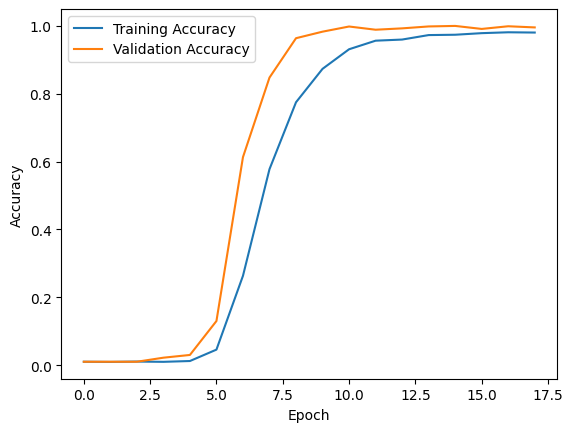

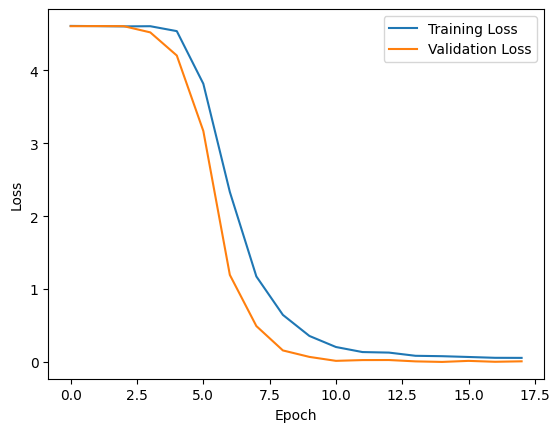

In [76]:
import matplotlib.pyplot as plt

train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

## 9. Test sample

In [77]:
import tensorflow as tf

final_model = tf.keras.models.load_model('Models/checkpoints/best_model_2011.keras')

In [78]:
def predict_action(keypoints_sequence, model):
    # normalized_sequence = []
    # for frame in keypoints_sequence:
    #     norm_frame = normalize_keypoints(frame)
    #     normalized_sequence.append(np.array(norm_frame).flatten())
    interp_sequence = interpolate_keypoints_sequence(keypoints_sequence)
    plot_keypoints_sequence_with_connections(interp_sequence)
    processed_sample = np.expand_dims(interp_sequence, axis=0)
    preds = model.predict(processed_sample, verbose=0)
    label = np.argmax(preds)
    confidence = preds[0][label]
    
    return label, confidence

### 9.1 Sample 1

In [79]:
path_test_video = "dataset/val_videos/máy tính laptop/may_tinh.mp4"
test_sequence = process_video_to_sequence(path_test_video, holistic)
print(len(test_sequence))

66


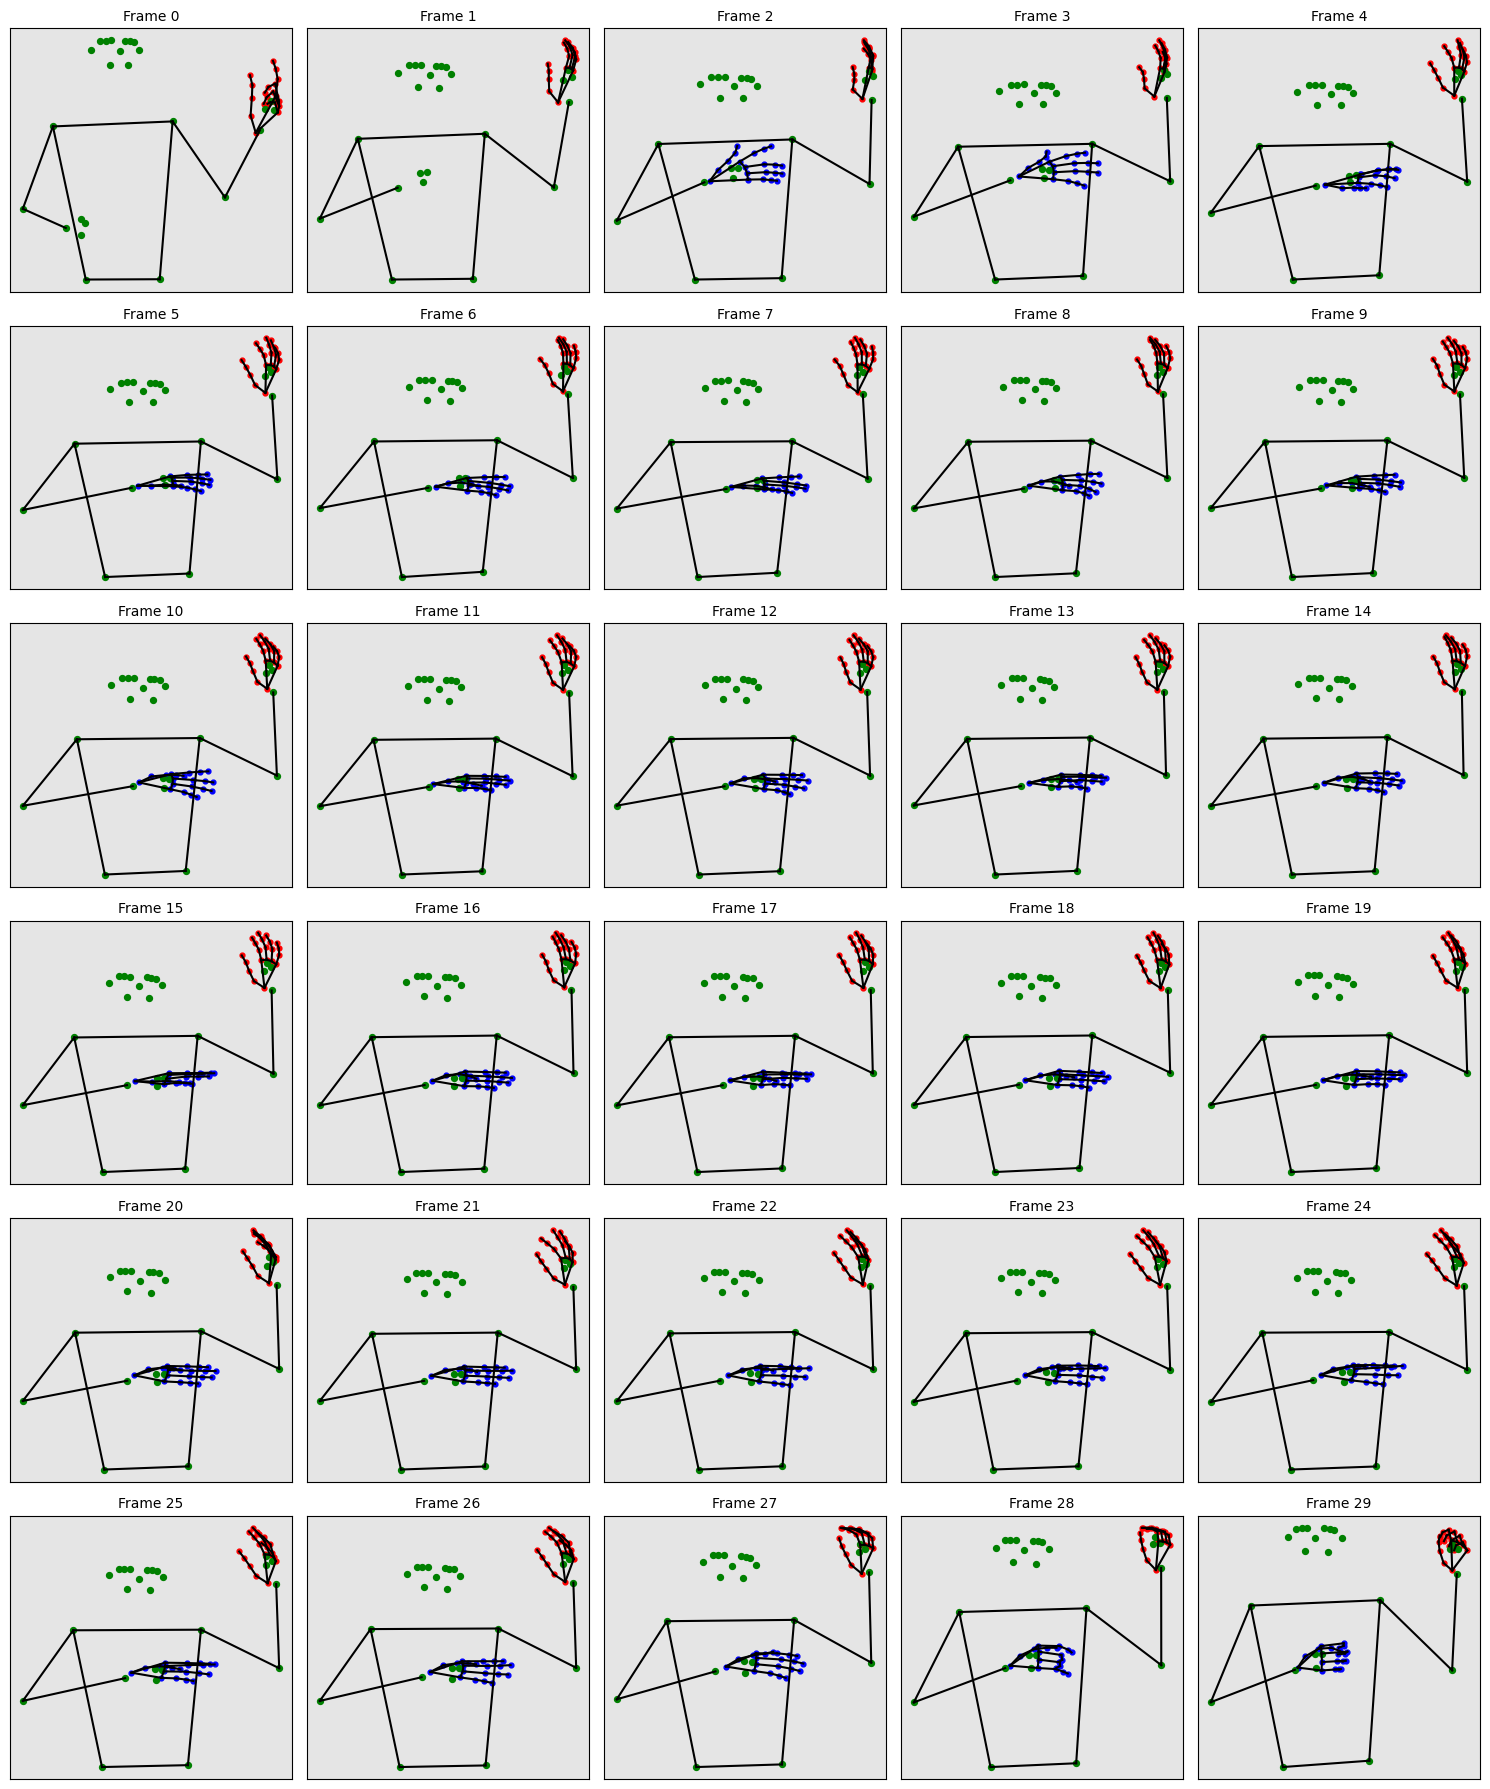

Predicted action: 52-máy tính laptop. Confidence: 0.7371855974197388.
Predicted action: máy tính laptop. Confidence: 0.7371855974197388.


In [80]:
test_pred, pred_conf = predict_action(test_sequence, final_model)
threshold = 0.7

print(f"Predicted action: {test_pred}-{num_to_label[test_pred]}. Confidence: {pred_conf}.")
if pred_conf > threshold:
    print(f"Predicted action: {num_to_label[test_pred]}. Confidence: {pred_conf}.")
else:
    print(f"Can not predict with confidence: {pred_conf}.")

### 9.2 Sample 2

In [81]:
test_sample2 = "dataset/val_videos/bàn ghế/ban_ghe_2.mp4"
test_2 = process_video_to_sequence(test_sample2, holistic)
new_test_2 = []
for frame in test_2:
    keypoints = frame.copy().reshape(N_LANDMARKS,3)
    keypoints[:,1] = 1 - keypoints[:,1]
    frame = keypoints.flatten()
    new_test_2.append(frame)
print(len(test_2))
print(len(new_test_2))

82
82


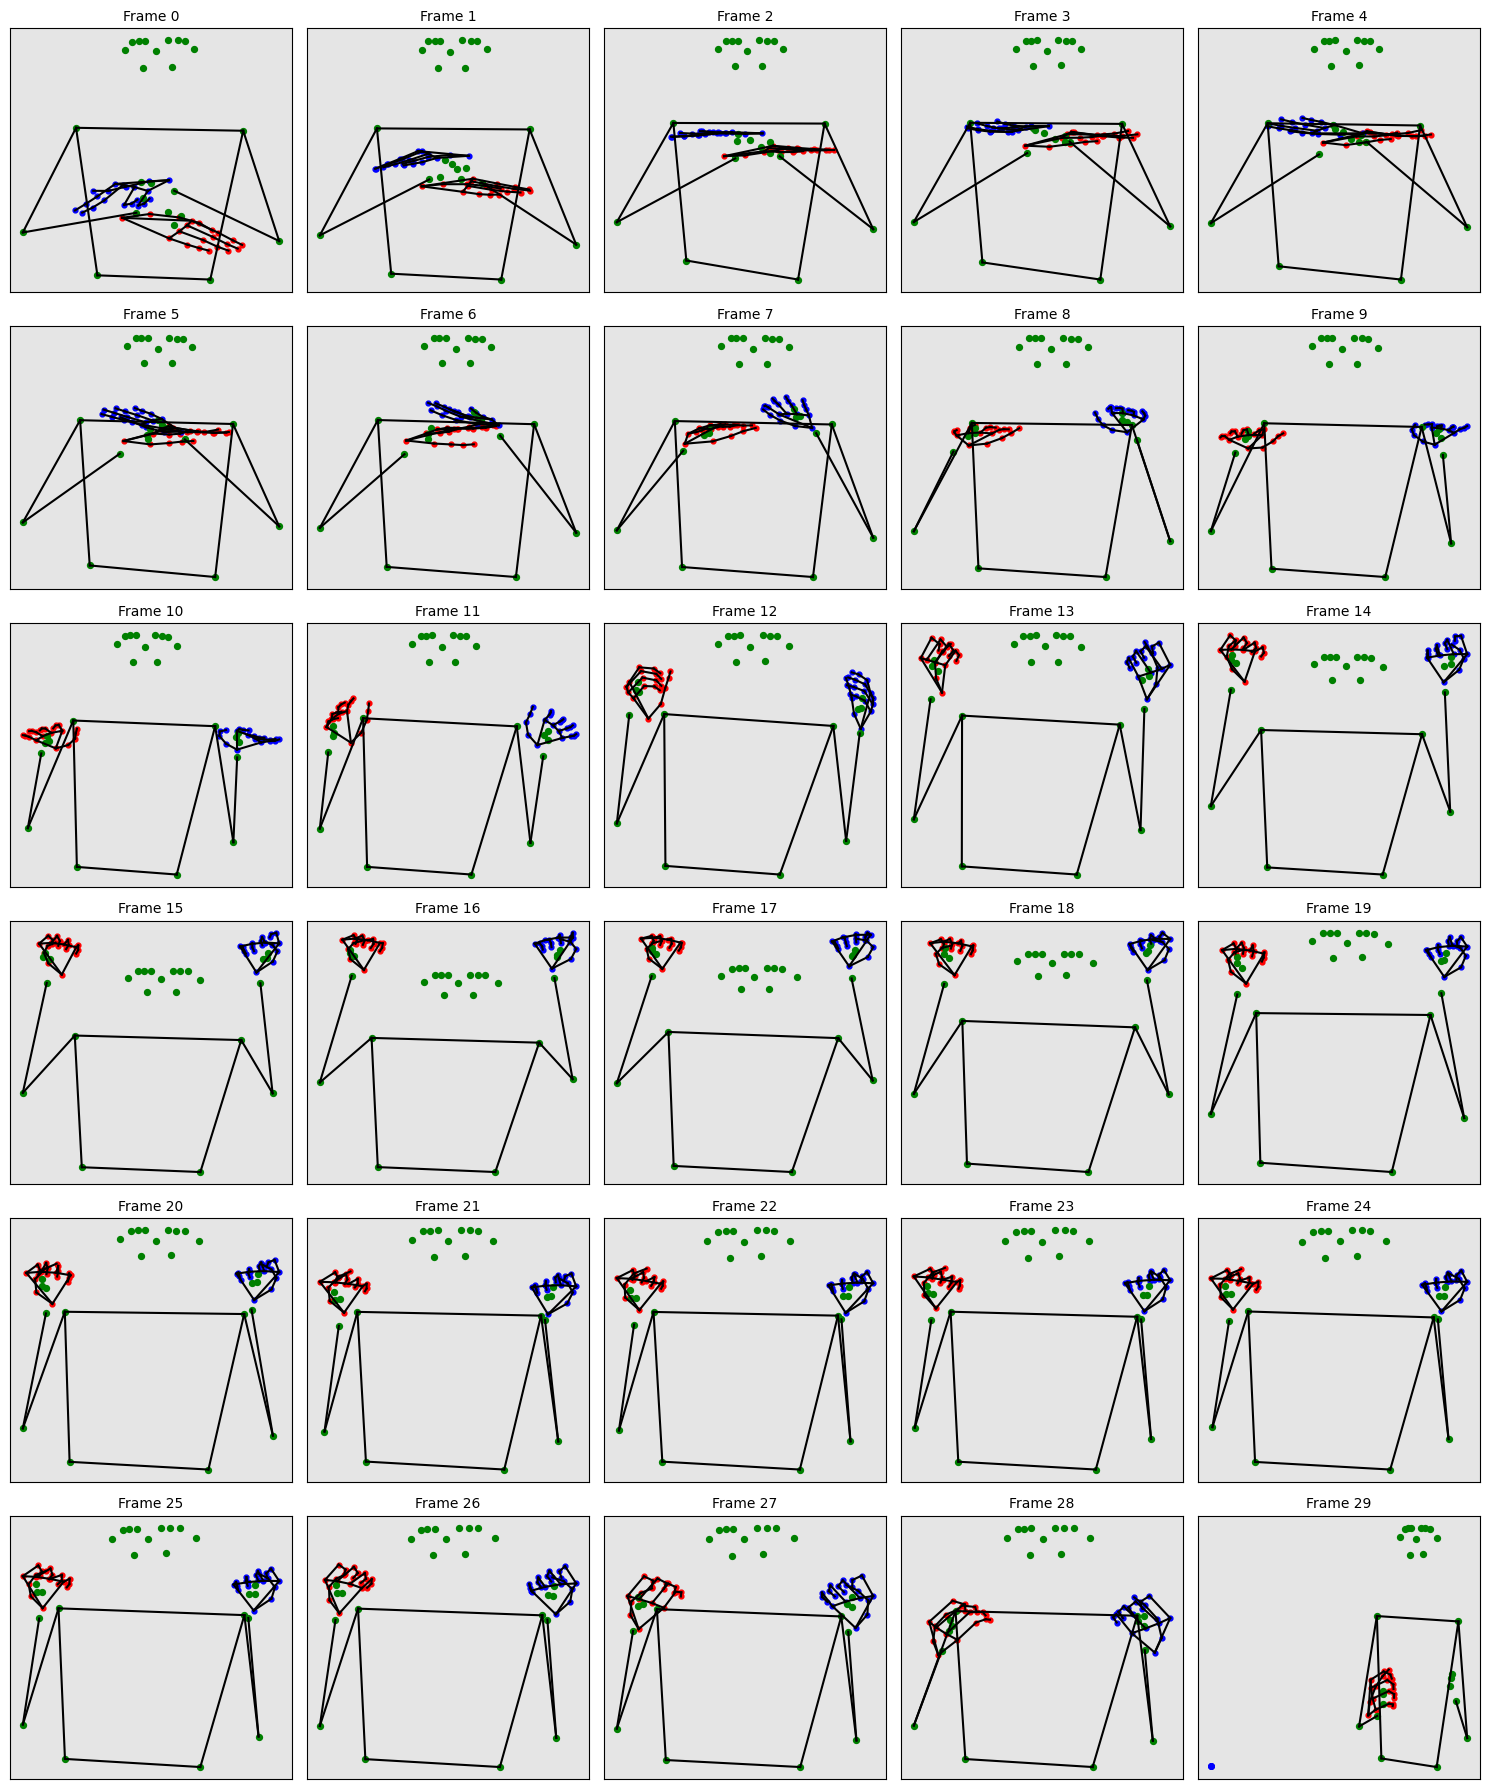

Predicted action: 13-bàn ghế. Confidence: 0.9883260130882263.
Predicted action: bàn ghế. Confidence: 0.9883260130882263.


In [82]:
test_pred, pred_conf = predict_action(new_test_2, final_model)
threshold = 0.7

print(f"Predicted action: {test_pred}-{num_to_label[test_pred]}. Confidence: {pred_conf}.")
if pred_conf > threshold:
    print(f"Predicted action: {num_to_label[test_pred]}. Confidence: {pred_conf}.")
else:
    print(f"Can not predict with confidence: {pred_conf}.")